### Time-Lagged Cross Correlation and Window Time Lagged Cross Correlation 

The purpose of this notebook is to develop a function for computing window time lagged cross correlation on two data arrays. I will work through a synthetic example and develop the function for use on real data 

useful links: 

https://medium.com/pythoneers/cross-correlation-and-coherence-in-time-series-analysis-how-to-uncover-relationships-between-c83a08990b2d


https://www.kaggle.com/code/adepvenugopal/time-series-correlation-pearson-tlcc-dtw






In [1]:
# import packages 
import numpy as np 
import matplotlib.pyplot as plt 
import xarray as xr 
import pandas as pd

import scipy
from scipy import signal
import colorcet as cc
import matplotlib
import cmocean 

In [2]:
# load in function that I previously copied from Una's code to test 


## ORIGINAL FUNCTION 

def sliding_window_correlation(ds1,ds2,lag_hours,sliding_window):

    """
    - ds1: dataset used for sliding window
    - ds2: dataset used for lag hours 

    """

    # calculate when correlation analysis should start 
    start = (ds1.time[0] + pd.Timedelta(lag_hours,'h'))
    end = (ds1.time[-1] - pd.Timedelta(lag_hours,'h'))

    # calculate sliding window indice based on lag_hours 
    
    sliding_window_indice = np.arange(-lag_hours,lag_hours+1,1)
    
    # calculate sliding window start and stop 
    window_stop = start + pd.Timedelta(sliding_window,'d')

    # calculate ndays
    ndays = (end-window_stop).values.astype('timedelta64[D]').astype('int')

    # calculate correlation stuff 
    corr = []
    pval = [] 
    
    for i in np.arange(0,ndays,1):
        start = (ds1.time[0] + pd.Timedelta(lag_hours,'h')) + pd.Timedelta(i,'d')
        stop = (ds1.time[0] + pd.Timedelta(lag_hours,'h') + pd.Timedelta(sliding_window,'d')) + pd.Timedelta(i,'d') 
        
        for hrs in range(len(sliding_window_indice)):
            
            sliding_start = ds1.sel(time=start).time + pd.Timedelta(sliding_window_indice[hrs],'hr')
            sliding_stop = ds1.sel(time=stop).time + pd.Timedelta(sliding_window_indice[hrs],'hr')
            
            x = signal.detrend(ds2.sel(time=slice(start,stop)))
            y = signal.detrend(ds1.sel(time=slice(sliding_start,sliding_stop)))
        
            r, p = scipy.stats.pearsonr(x, y)
            corr.append(r)
            pval.append(p)

    # convert to good format 
    corr  = np.reshape(corr, [len(np.arange(0,ndays)),len(sliding_window_indice)]) 
    pval  = np.reshape(pval, [len(np.arange(0,ndays)),len(sliding_window_indice)]) 

    start = (ds1.time[0] + pd.Timedelta(lag_hours,'h'))
    end = (ds1.time[-1] - pd.Timedelta(lag_hours,'h'))

    start_date = (ds1.time[0] + pd.Timedelta(lag_hours,'h')).values
    date_array = [start_date + np.timedelta64(i, 'D') for i in range(ndays)]


    corr = xr.DataArray(data=corr,dims=['days','lag_hours'],
             coords=dict(days=date_array,lag_hours=sliding_window_indice))

    pval = xr.DataArray(data=pval,dims=['days','lag_hours'],
                 coords=dict(days=date_array,lag_hours=sliding_window_indice))

    return corr, pval

In [3]:
def Plot_Corr_Pval(corr,pval,title):
    
    """ Plotting function for plotting sliding window correlations"""
    
    corr_significant = corr
    corr_significant = corr_significant.where(pval < 0.05)
    fig=plt.figure(figsize=(6,6),dpi=300) 
    
    cmap = cmocean.cm.balance  #CET_D1A #matplotlib.cm.Spectral_r
    bounds = np.arange(-0.9,1,.2)
    norm =  matplotlib.colors.BoundaryNorm(bounds, cmap.N)
    
    
    plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )
    
    plt.gca().invert_yaxis()
    cbar = plt.colorbar()
    cbar.set_label('$R$')
    
    
    plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [0.6,1], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)
    plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)
    
    # plt.xlim(-100,100)
    plt.axvline(x=0,color='k',linestyle='dashed')
    
    plt.title(title)
    plt.tight_layout()



In [4]:
# create some fake data and a fake situation 
# consider: 

### Play around with fake signals 

In [7]:
# create a fake signal 
t = np.arange(0,100,1)
test_signal = np.sin(t)

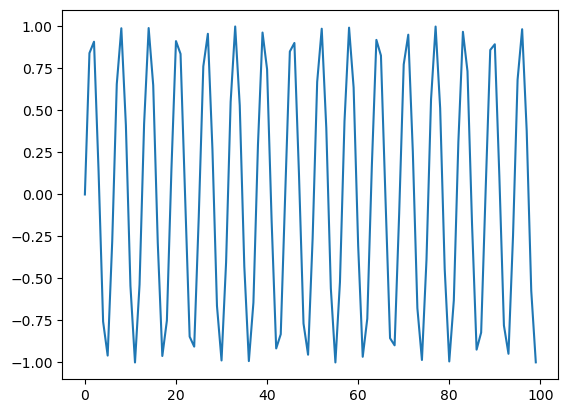

In [8]:
plt.plot(t,test_signal)

In [20]:
import numpy as np
import xarray as xr

# --- Define time dimension ---
time = np.arange(np.datetime64("2020-01-01"), np.datetime64("2020-01-14"), np.timedelta64(10, "m"))

# --- Create a synthetic signal ---
# Temperature:
# Base temperature (in °C)
base_temp = 5  

# Add diurnal cycle + a slower trend + random noise
temp = (
    base_temp
    + 0.5 * np.sin(2 * np.pi * (np.arange(len(time)) / (24 * 6)))   # daily cycle
    + 0.2 * np.sin(2 * np.pi * (np.arange(len(time)) / (24 * 6 * 10)))  # slower oscillation
    + 0.05 * np.random.randn(len(time))  # random noise
)


# --- Create a lagged version (e.g., 3-hour lag) ---
lag_hours = 12
lag_samples = int(lag_hours * 60 / 10)  # because Δt = 10 minutes

da_temp_lagged = da_temp.roll(time=lag_samples, roll_coords=False)
da_temp_lagged = da_temp_lagged + 0.02 * np.random.randn(len(time))  # add independent noise

da_temp_lagged.name = "temperature_lagged"

# --- Create xarray DataArray ---
da_temp = xr.DataArray(
    temp,
    coords={"time": time},
    dims="time",
    name="temperature",
    attrs={"units": "°C", "description": "synthetic 1D temperature time series"}
)

# --- Wrap in Dataset (optional) ---
ds = xr.Dataset({"temperature": da_temp, "temperature_lagged": da_temp_lagged})

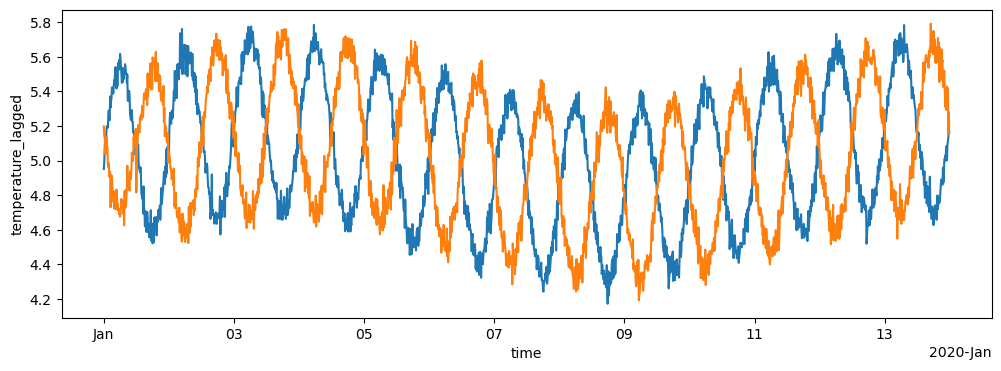

In [22]:
fig = plt.figure(figsize=(12,4))
ds.temperature.plot()
ds.temperature_lagged.plot()

In [ ]:
temp_lagged = (
    base_temp
    + 0.5 * np.sin(2 * np.pi * (np.arange(len(time)) / (24 * 6)))   # daily cycle
    + 0.2 * np.sin(2 * np.pi * (np.arange(len(time)) / (24 * 6 * 10)))  # slower oscillation
    + 0.05 * np.random.randn(len(time))    # random noise
    
)

### Load in Some Real Data 

In [4]:
# load in TNBD data 
tnbd_vel1000 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/vel_1000.nc')
tnbd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/vel_1100.nc')

tnbd_sbe1000 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1000.nc')
tnbd_sbe1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1100.nc')

In [5]:
# load in DITD data 
ditd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/DITD_2018_2019/vel_1100.nc')
ditd_vel1200 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/DITD_2018_2019/vel_1200.nc')

ditd_sbe1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/DITD_2018_2019/sbe_1100.nc')
ditd_sbe1200 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/DITD_2018_2019/sbe_1200.nc')

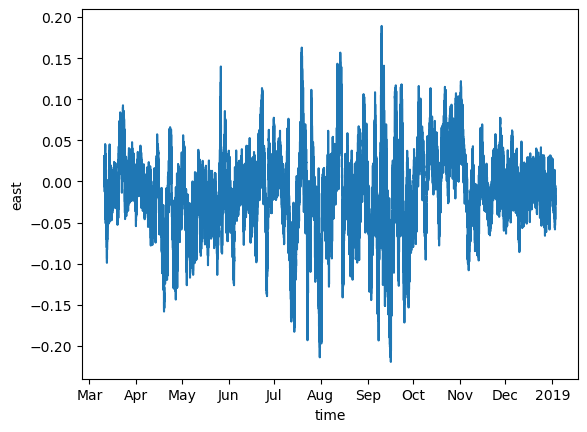

In [6]:
ditd_vel1100.east.plot()

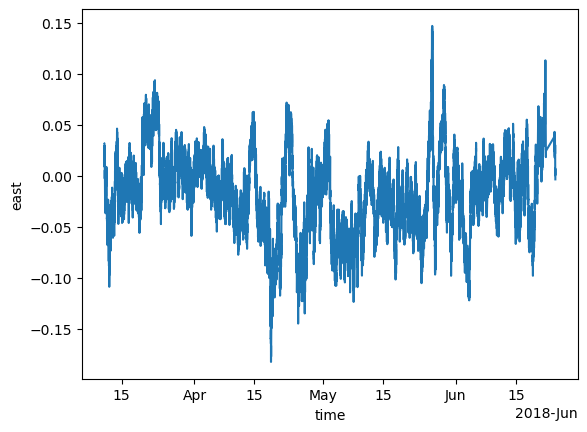

In [7]:
ditd_vel1200.east.plot()

In [8]:
# FIX TIME - SUBTRACT 12 hours from upper sensor 
ditd_vel1100['time'] = ditd_vel1100.time - pd.Timedelta(12,'h')

In [9]:
ditd_vel1100.time

<xarray.DataArray 'time' (time: 42912)> Size: 343kB
array(['2018-03-10T12:00:00.000000000', '2018-03-10T12:10:00.000000000',
       '2018-03-10T12:20:00.000000000', ..., '2019-01-02T11:30:00.000000000',
       '2019-01-02T11:40:00.000000000', '2019-01-02T11:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    index    (time) int64 343kB ...
  * time     (time) datetime64[ns] 343kB 2018-03-10T12:00:00 ... 2019-01-02T1...

In [10]:
ditd_vel1200.time

<xarray.DataArray 'time' (time: 14868)> Size: 119kB
array(['2018-03-11T00:00:00.000000000', '2018-03-11T00:10:00.000000000',
       '2018-03-11T00:20:00.000000000', ..., '2018-06-24T04:33:18.000000000',
       '2018-06-24T04:43:18.000000000', '2018-06-24T04:53:18.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    index    (time) int64 119kB ...
  * time     (time) datetime64[ns] 119kB 2018-03-11 ... 2018-06-24T04:53:18

In [11]:
# align times 
ditd_vel1200 = ditd_vel1200.sel(time=slice('2018-03-11','2018-06-18'))
ditd_vel1100 = ditd_vel1100.sel(time=slice('2018-03-11','2018-06-18'))

In [12]:
depth = np.array([1100,1200])

In [13]:
# merge datasets together under a new dimension 
vel_ditd = xr.concat([ditd_vel1100,ditd_vel1200],depth).rename_dims({'concat_dim':'depth'})

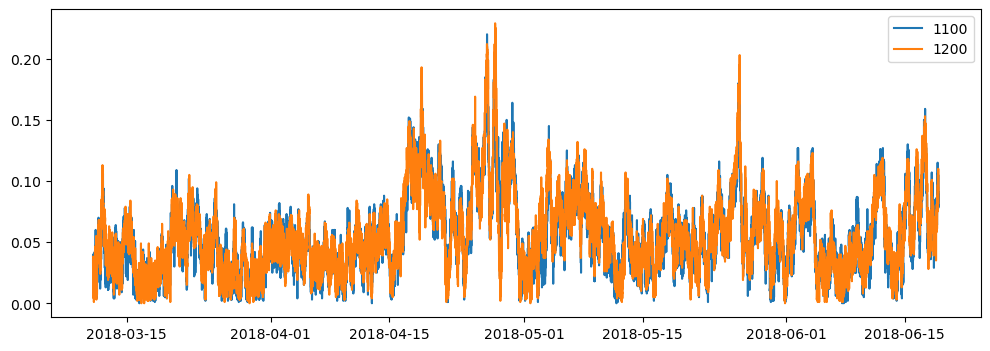

In [14]:
# plot the full time series 
fig = plt.figure(figsize=(12,4))
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1000')
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1100')
# plt.legend()

plt.plot(vel_ditd.time,vel_ditd.isel(depth=0).speed,label='1100')
plt.plot(vel_ditd.time,vel_ditd.isel(depth=1).speed,label='1200')
plt.legend()

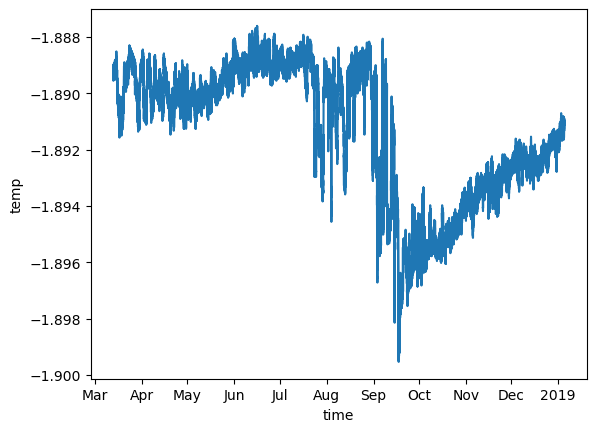

In [15]:
tnbd_sbe1100.temp.plot()

In [16]:
# FIX TIME 
tnbd_vel1100['time'] = tnbd_vel1100.time - pd.Timedelta(24,'h')

In [17]:
# resample to same time and dates
tnbd_vel1100 = tnbd_vel1100.resample(time='30min').mean()

In [18]:
tnbd_vel1100 = tnbd_vel1100.sel(time=slice('2018-03-13','2019-01-03'))

In [19]:
depth = np.array([1000,1100])

In [20]:
# merge datasets together under a new dimension 
vel = xr.concat([tnbd_vel1000,tnbd_vel1100],depth).rename_dims({'concat_dim':'depth'})

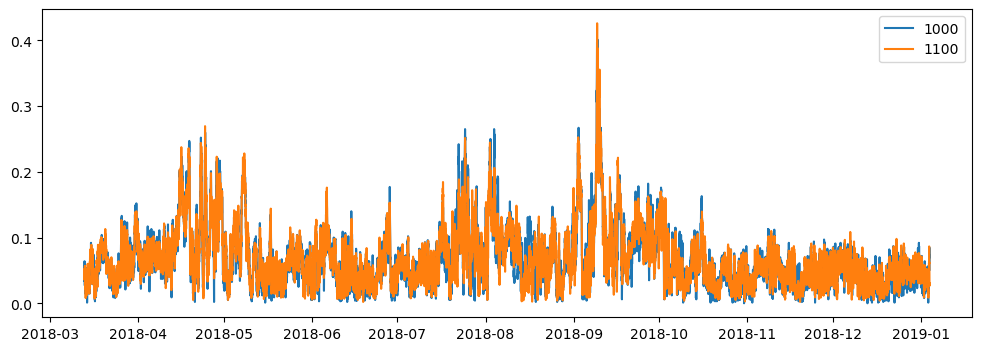

In [21]:
# plot the full time series 
fig = plt.figure(figsize=(12,4))
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1000')
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1100')
# plt.legend()

plt.plot(vel.time,vel.isel(depth=0).speed,label='1000')
plt.plot(vel.time,vel.isel(depth=1).speed,label='1100')
plt.legend()

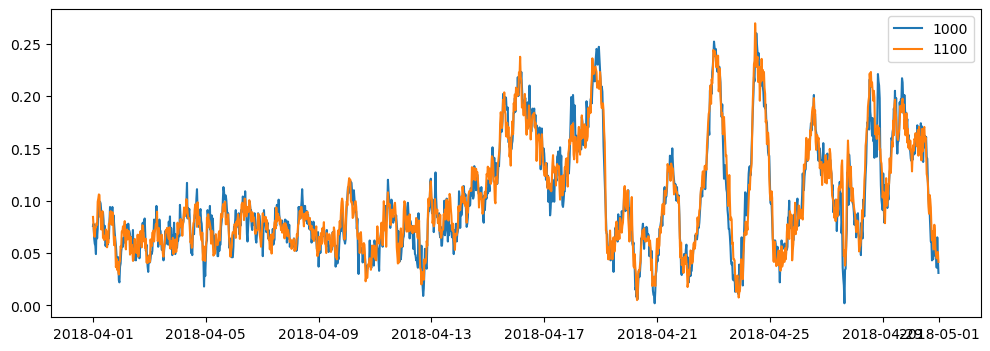

In [22]:
# plot a small subset of speed at each depth 
fig = plt.figure(figsize=(12,4))
plt.plot(vel.sel(time=slice('2018-04-01','2018-04-30')).time,vel.sel(time=slice('2018-04-01','2018-04-30')).isel(depth=0).speed,label='1000')
plt.plot(vel.sel(time=slice('2018-04-01','2018-04-30')).time,vel.sel(time=slice('2018-04-01','2018-04-30')).isel(depth=1).speed,label='1100')
plt.legend()

### Sliding Window Correlation - TNBD Speed 1100 and 1000 meters

In [23]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel.isel(depth=1).speed,
                                        ds2 = vel.isel(depth=0).speed,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_21029/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_21029/209530569.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)


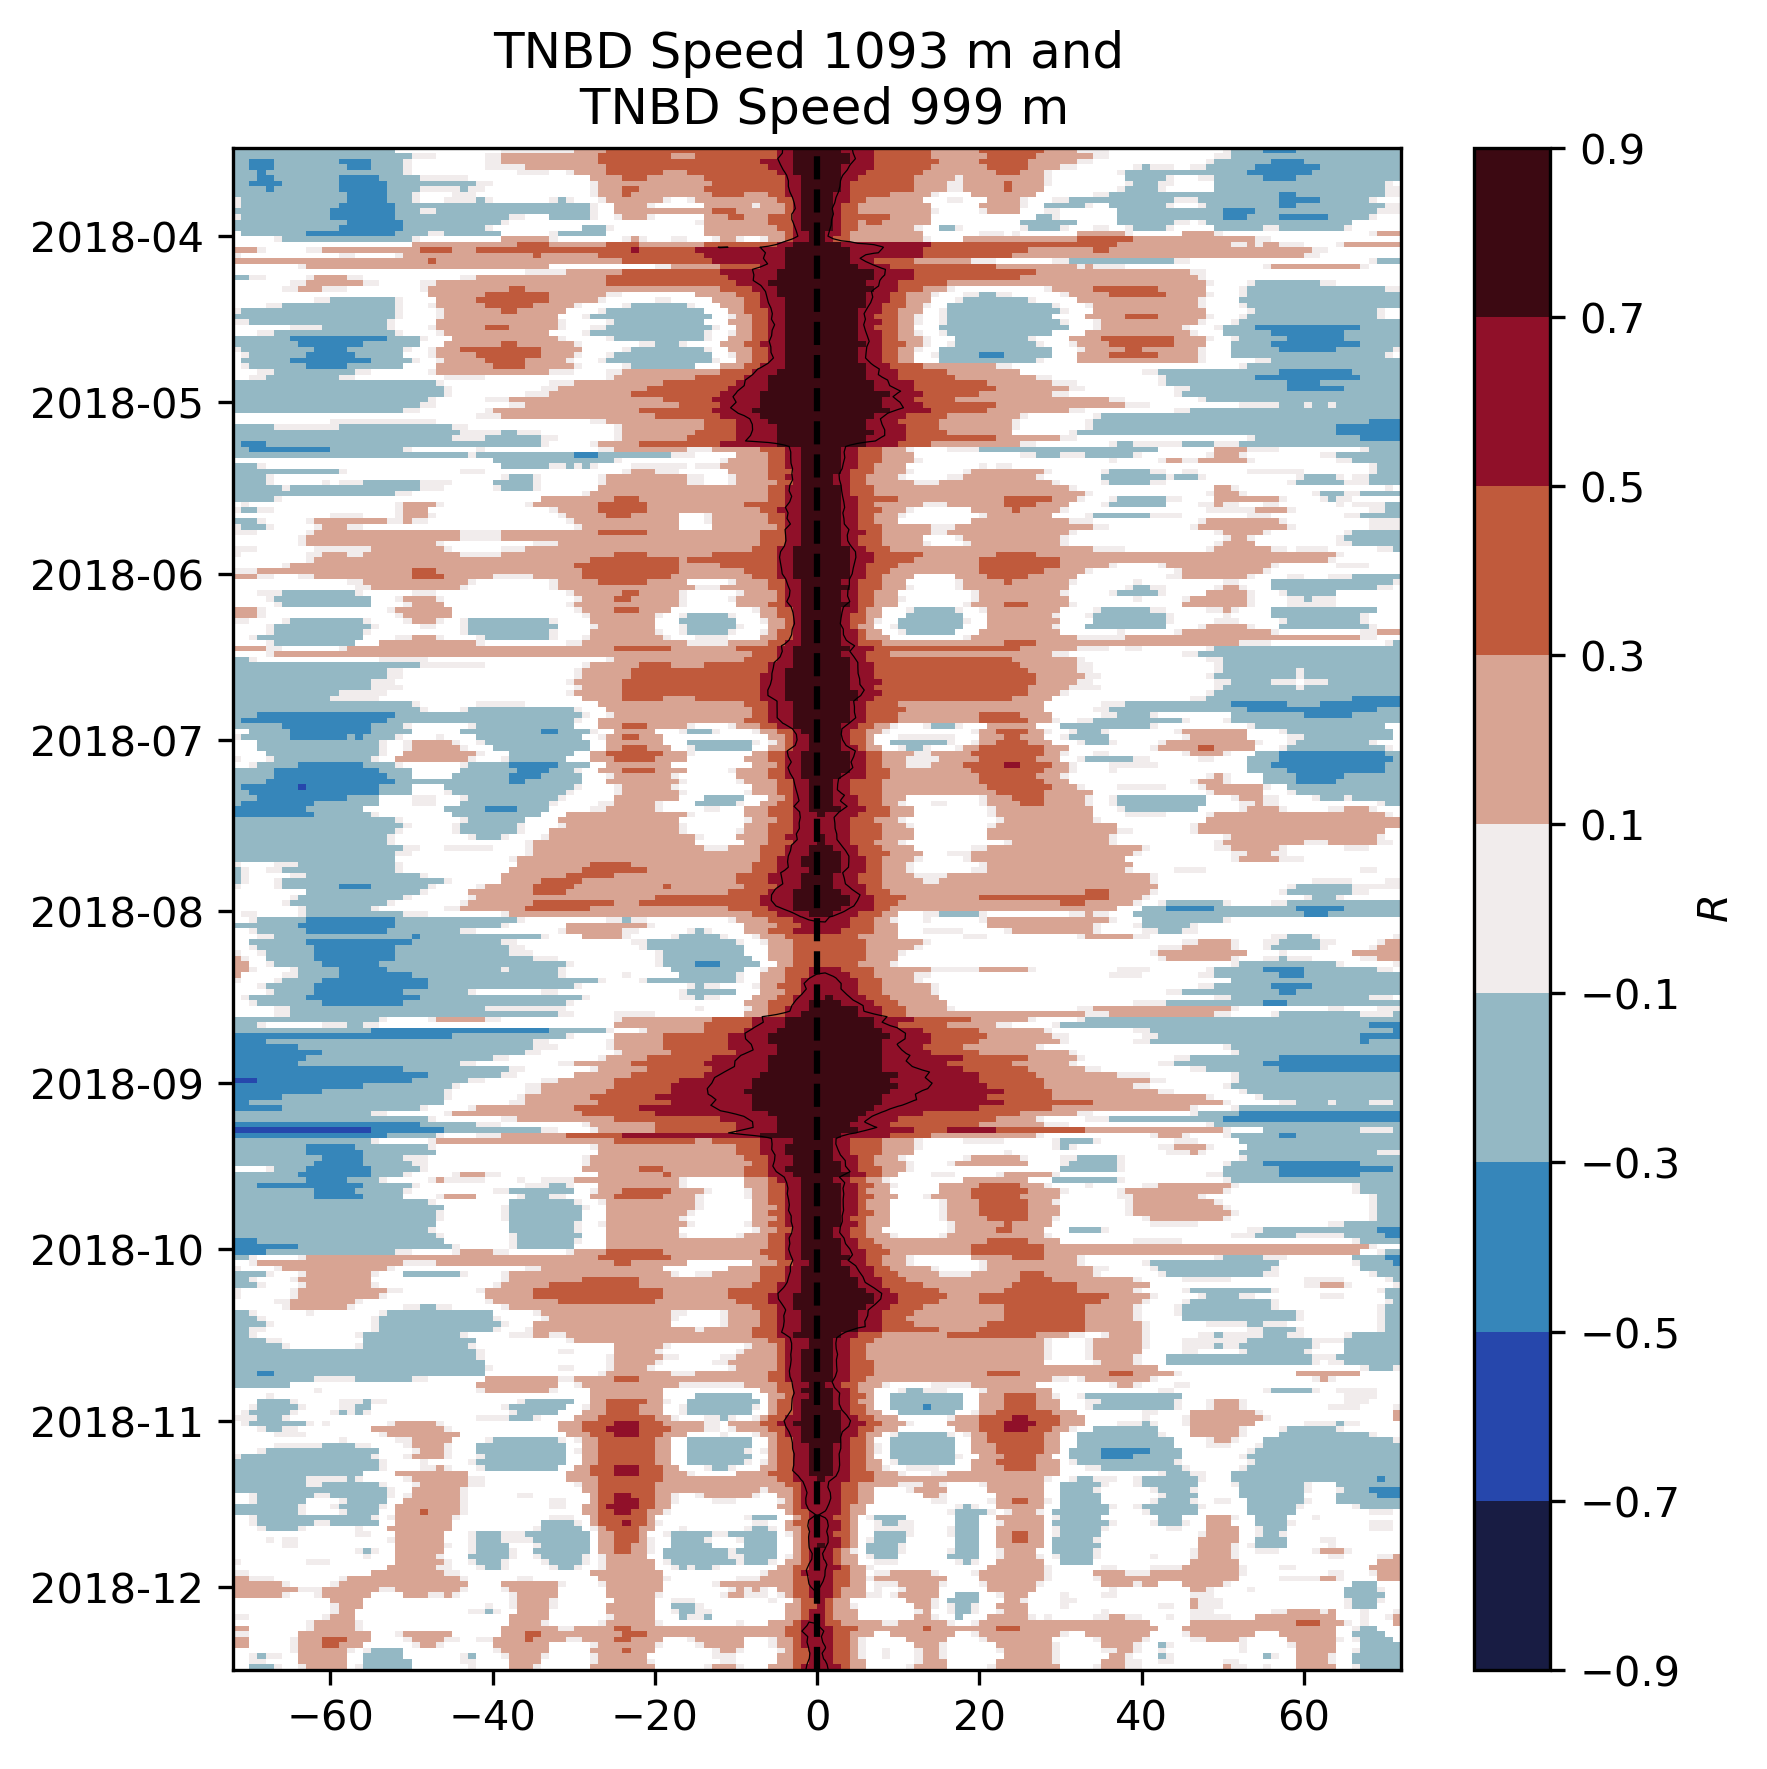

In [25]:
Plot_Corr_Pval(title='TNBD Speed 1093 m and \n TNBD Speed 999 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)

Text(0.5, 1.0, 'In-Situ Data')

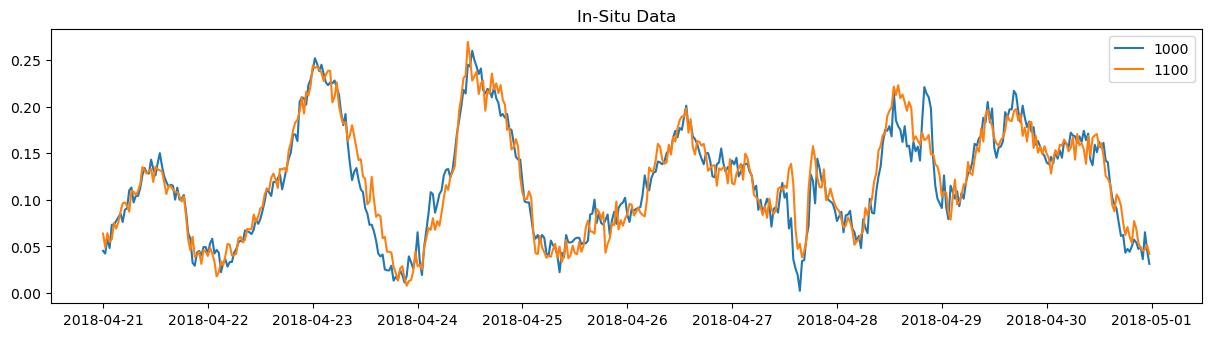

In [26]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1000')
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1100')
plt.legend()
plt.title('In-Situ Data')

# plt.subplot(2,1,2)
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1000')
# plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1100')
# plt.legend()
# plt.title('Aligned Time Series')



### Sliding Window Correlation - TNBD Zonal Velocity 1100 and 1000 meters 

In [40]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel.isel(depth=1).east,
                                        ds2 = vel.isel(depth=0).east,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )


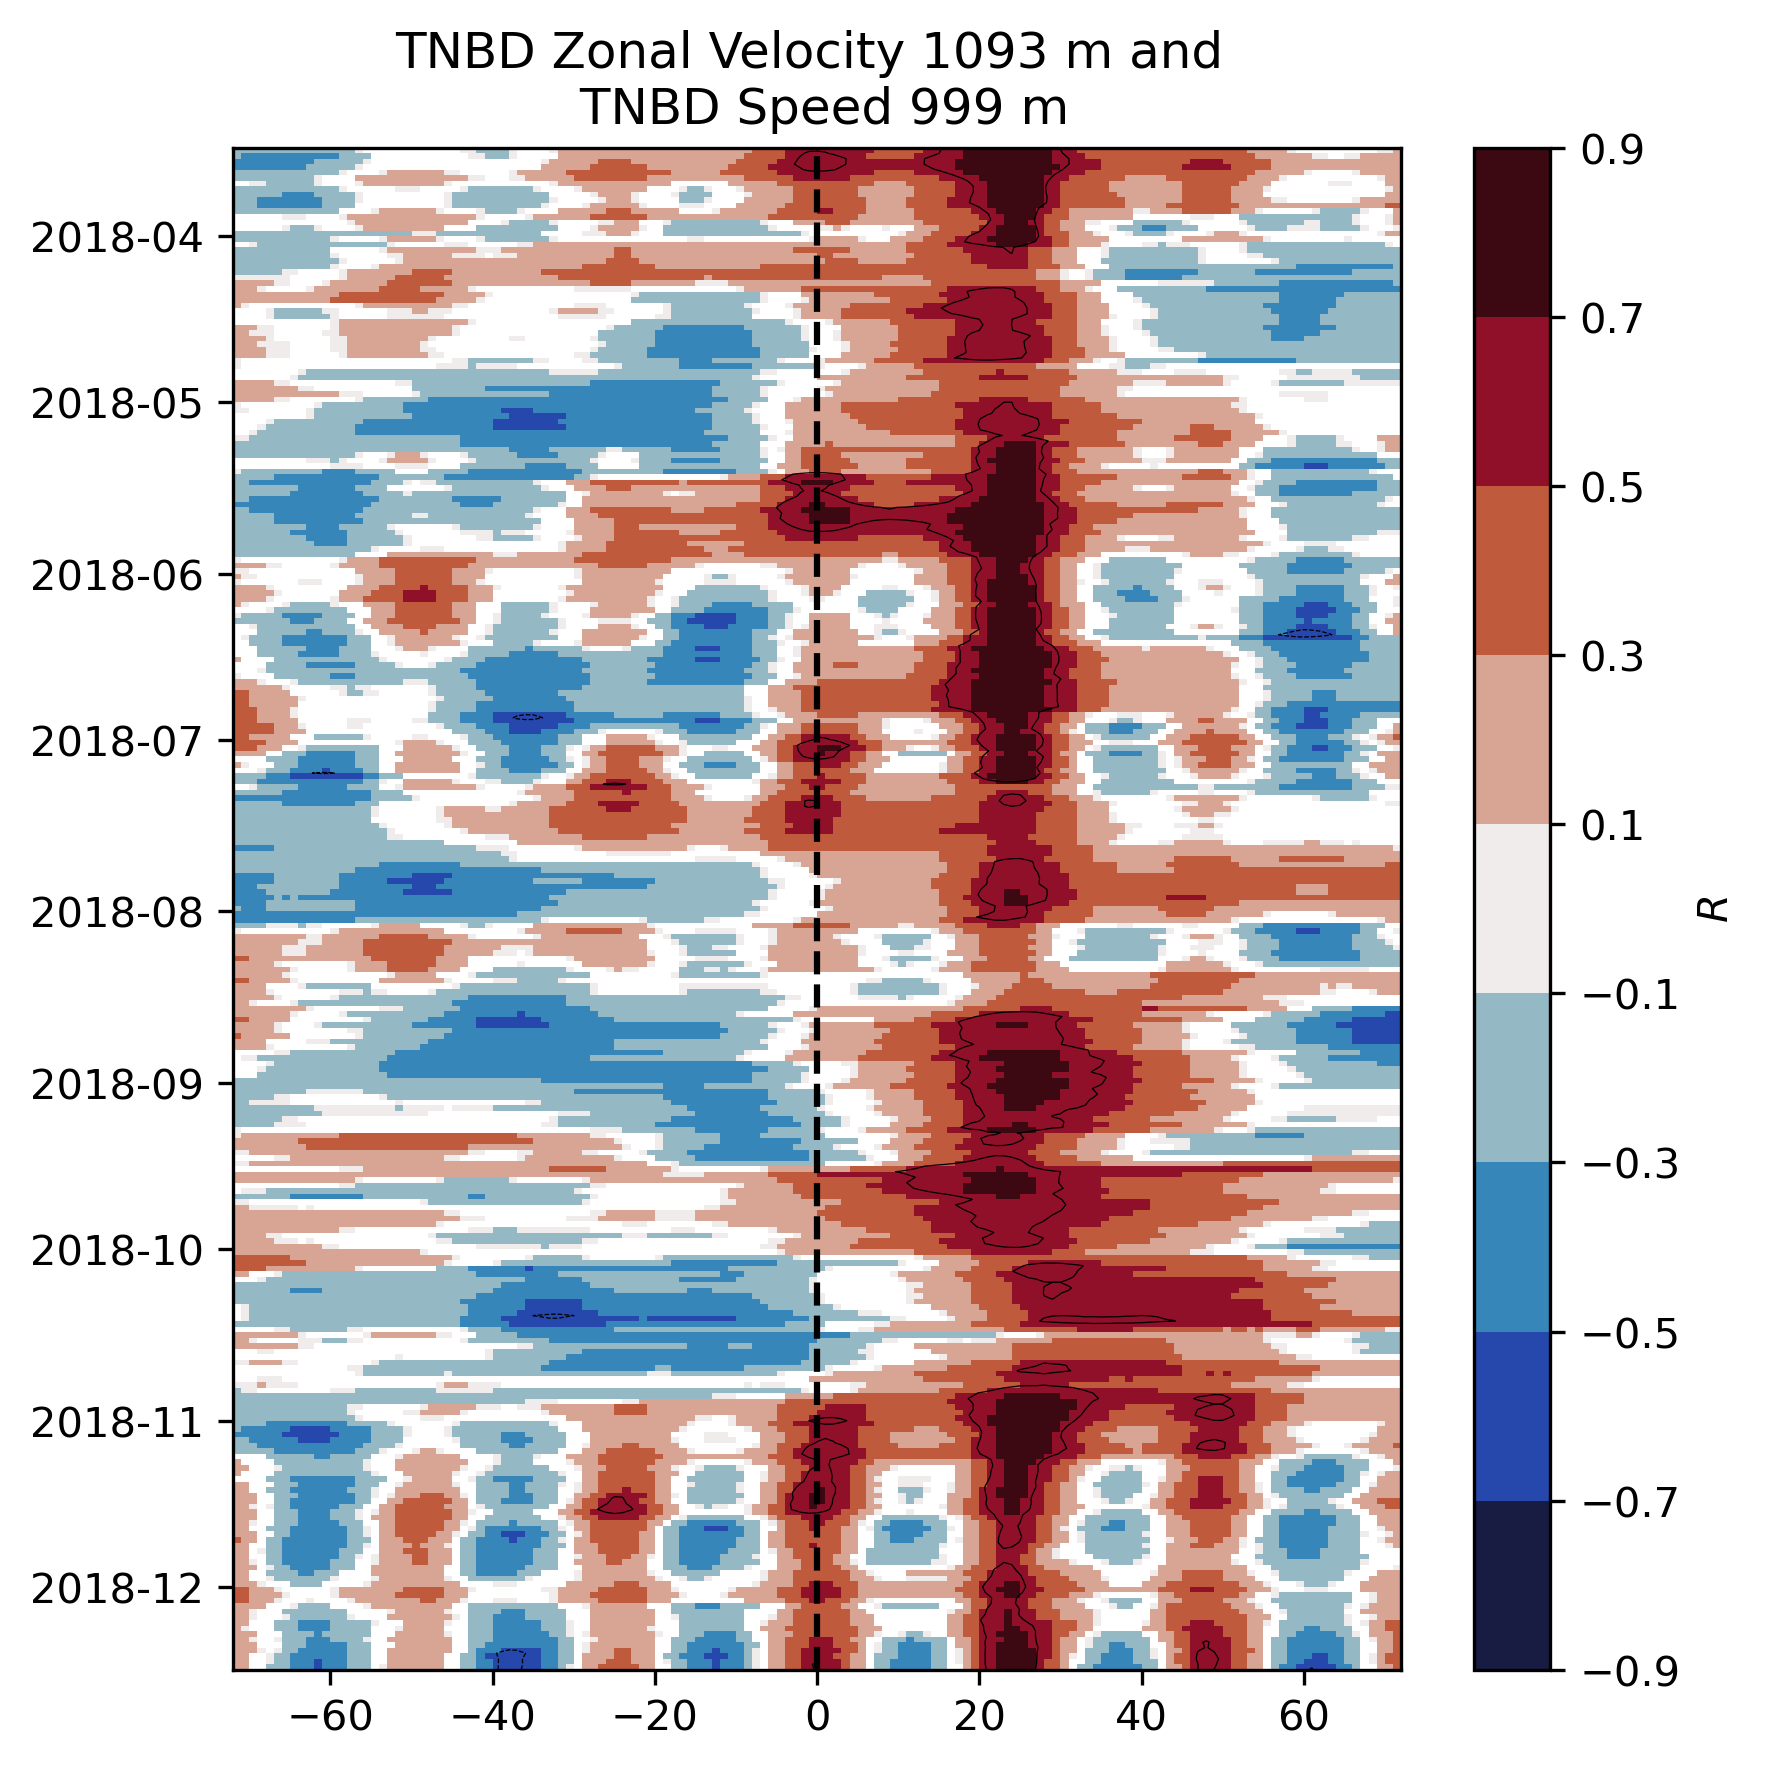

In [41]:
Plot_Corr_Pval(title='TNBD Zonal Velocity 1093 m and \n TNBD Speed 999 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)

Text(0.5, 1.0, 'Aligned Time Series')

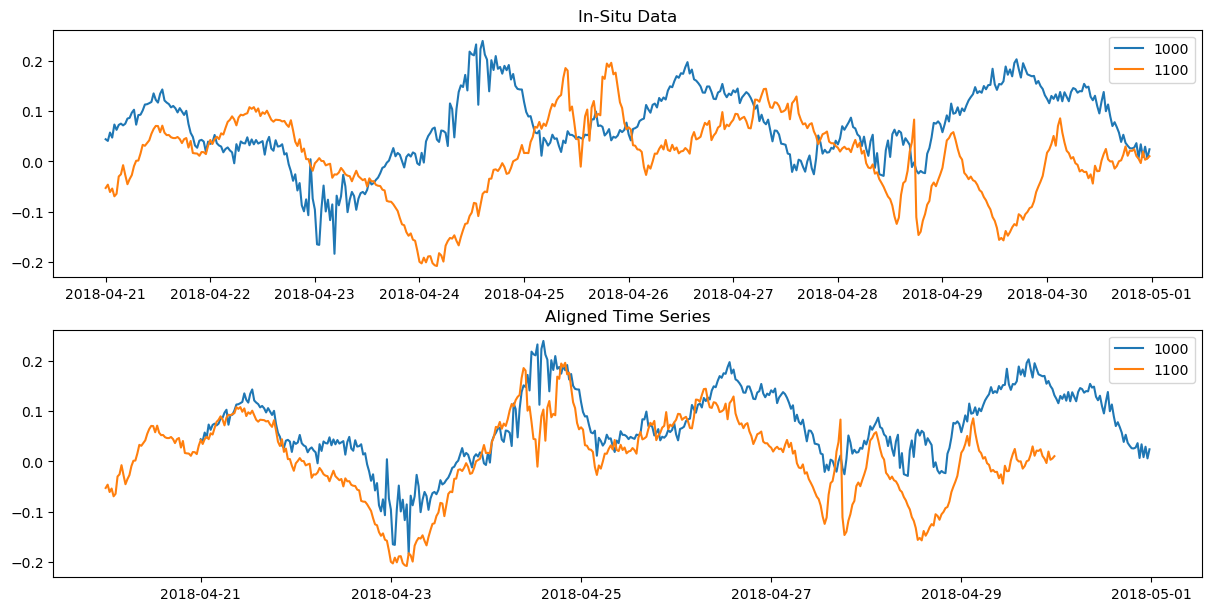

In [42]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('Aligned Time Series')



### Sliding Window Correlation - TNBD Meridional Velocity 1100 and 1000 meters

In [44]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel.isel(depth=1).north,
                                        ds2 = vel.isel(depth=0).north,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )


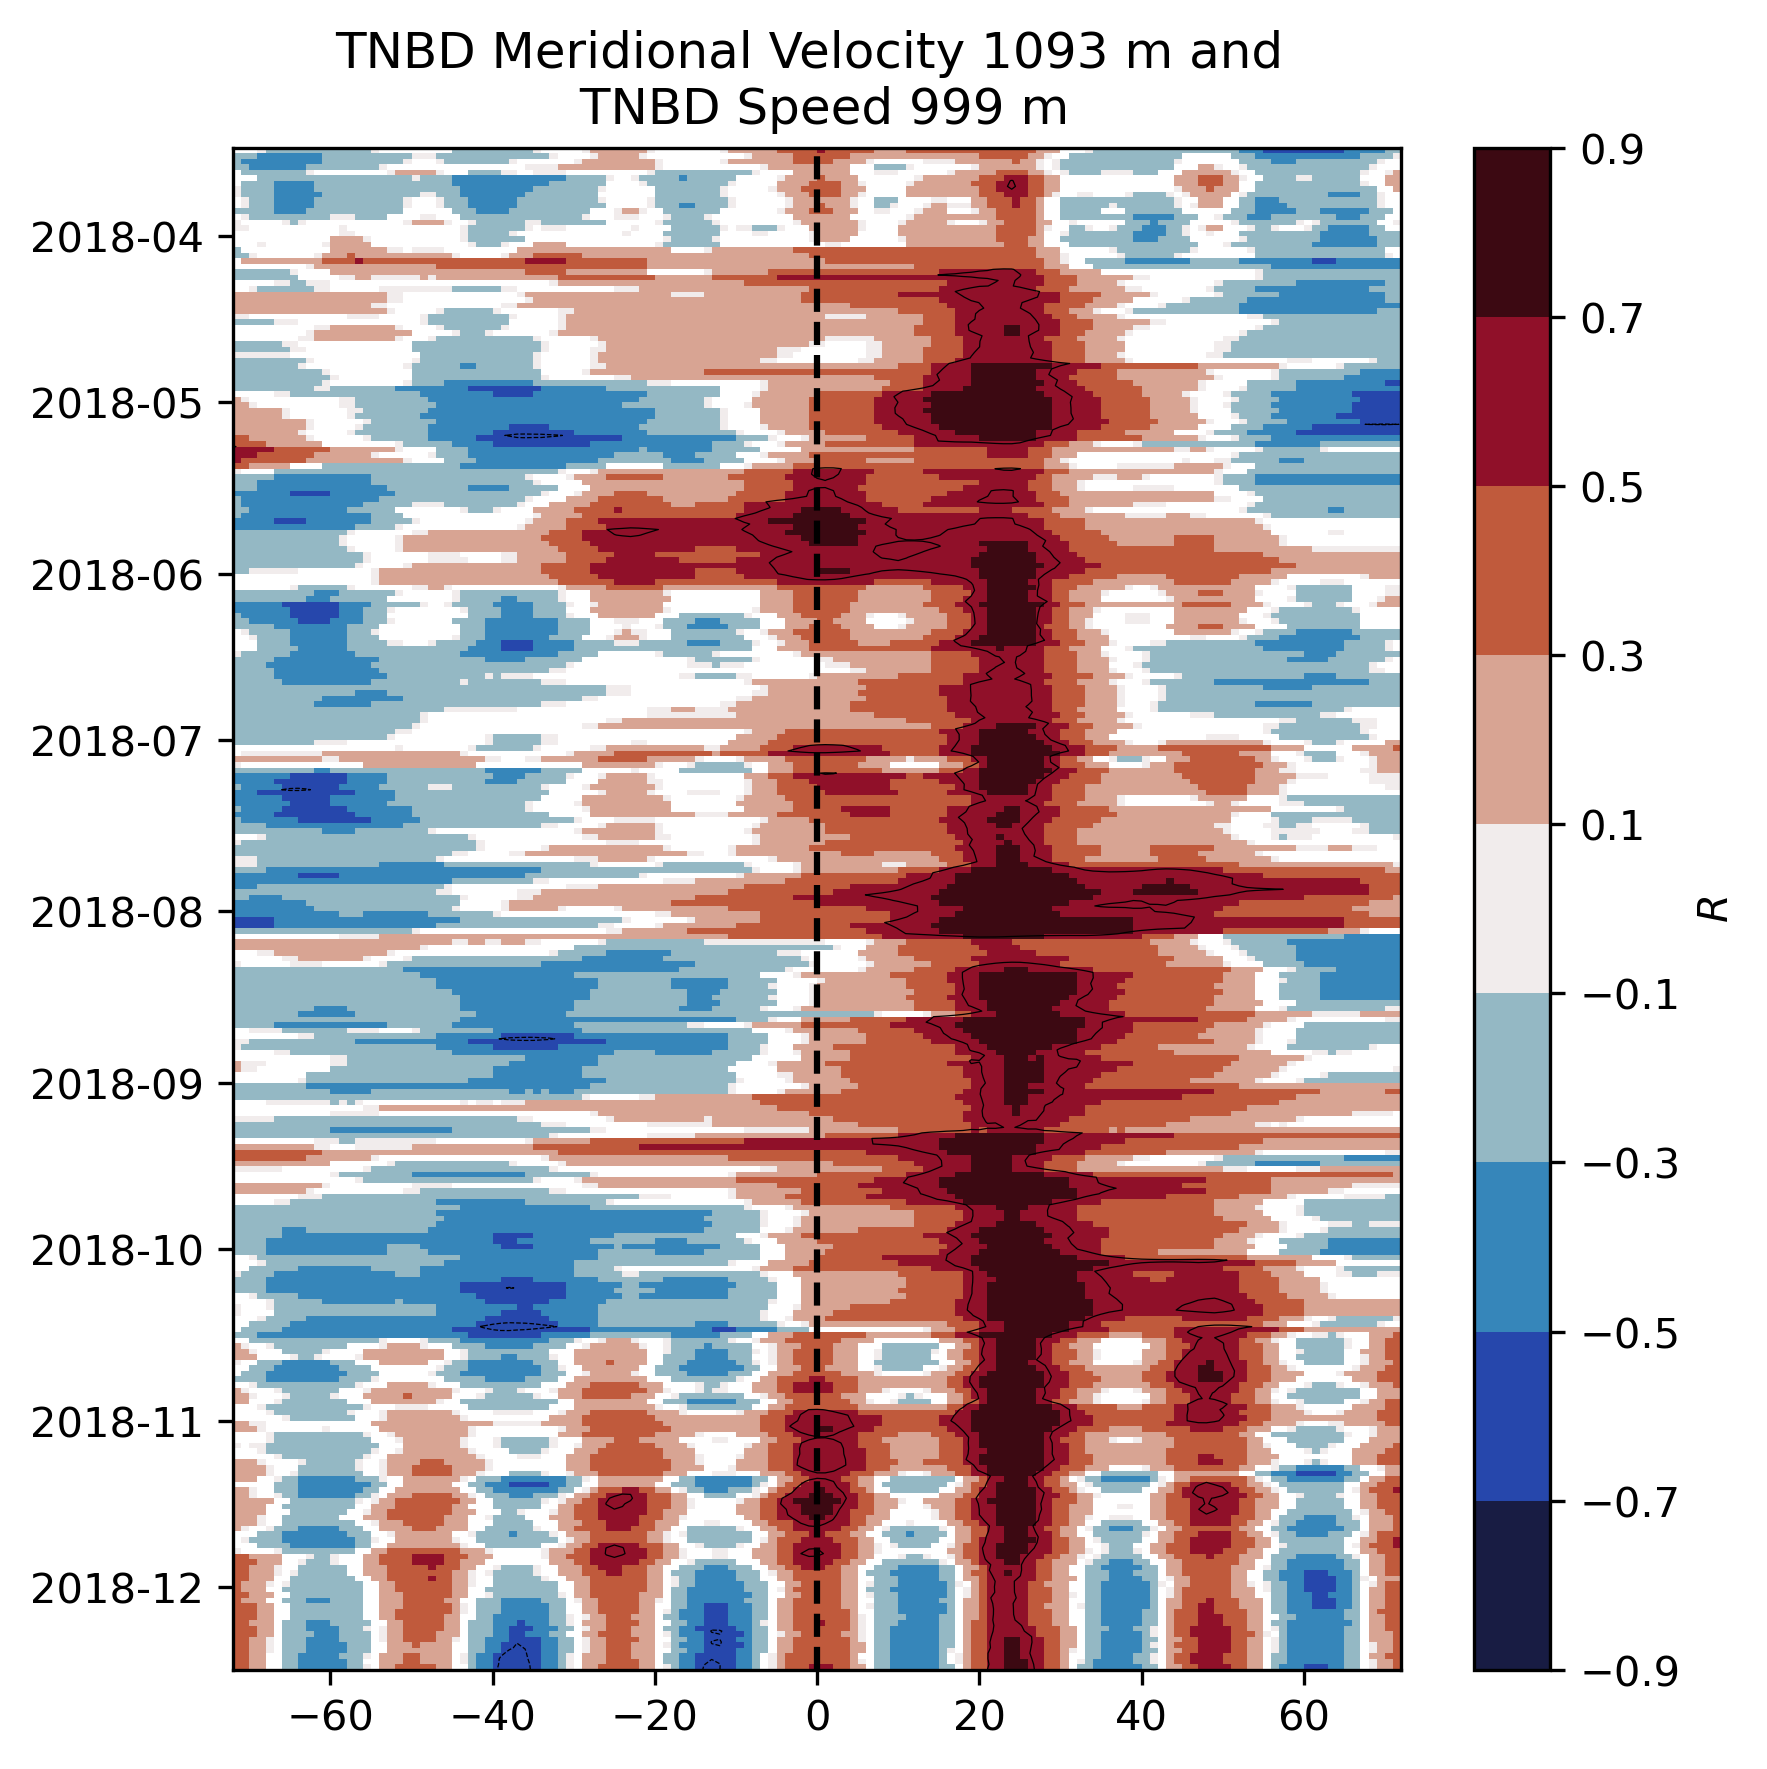

In [45]:
Plot_Corr_Pval(title='TNBD Meridional Velocity 1093 m and \n TNBD Speed 999 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)

Text(0.5, 1.0, 'Aligned Time Series')

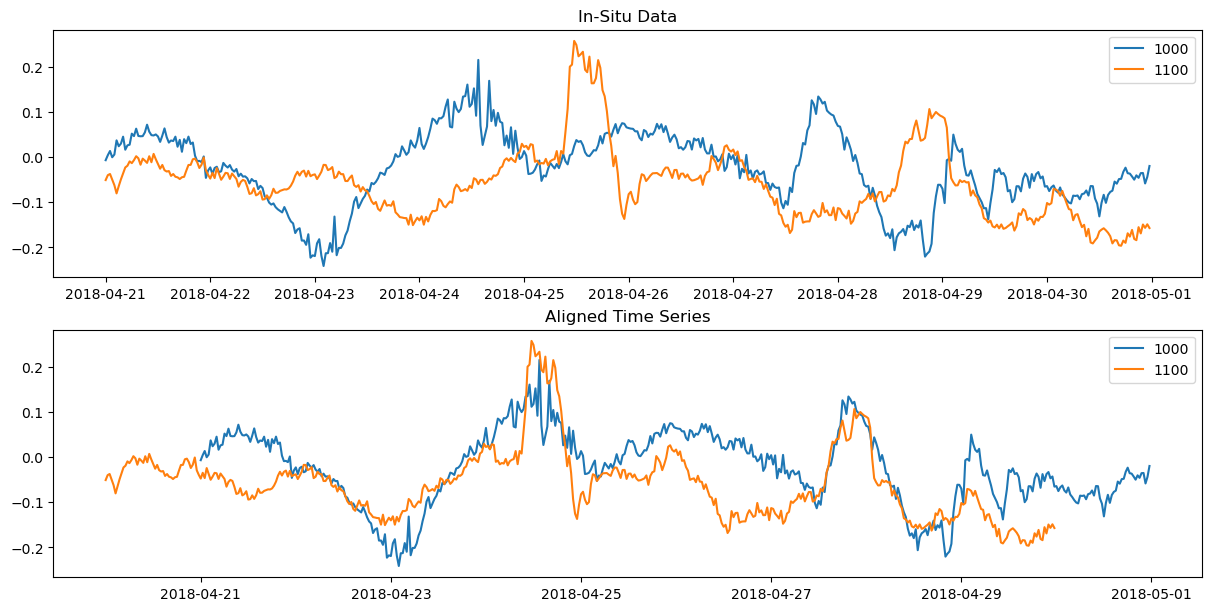

In [46]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).north,label='1000')
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).north,label='1100')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time,vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).north,label='1000')
plt.plot(vel.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).north,label='1100')
plt.legend()
plt.title('Aligned Time Series')



### Sliding Window Correlation - DITD Speed 1200 and 1100 meters

In [68]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel_ditd.isel(depth=1).speed,
                                        ds2 = vel_ditd.isel(depth=0).speed,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)


(-20.0, 0.0)

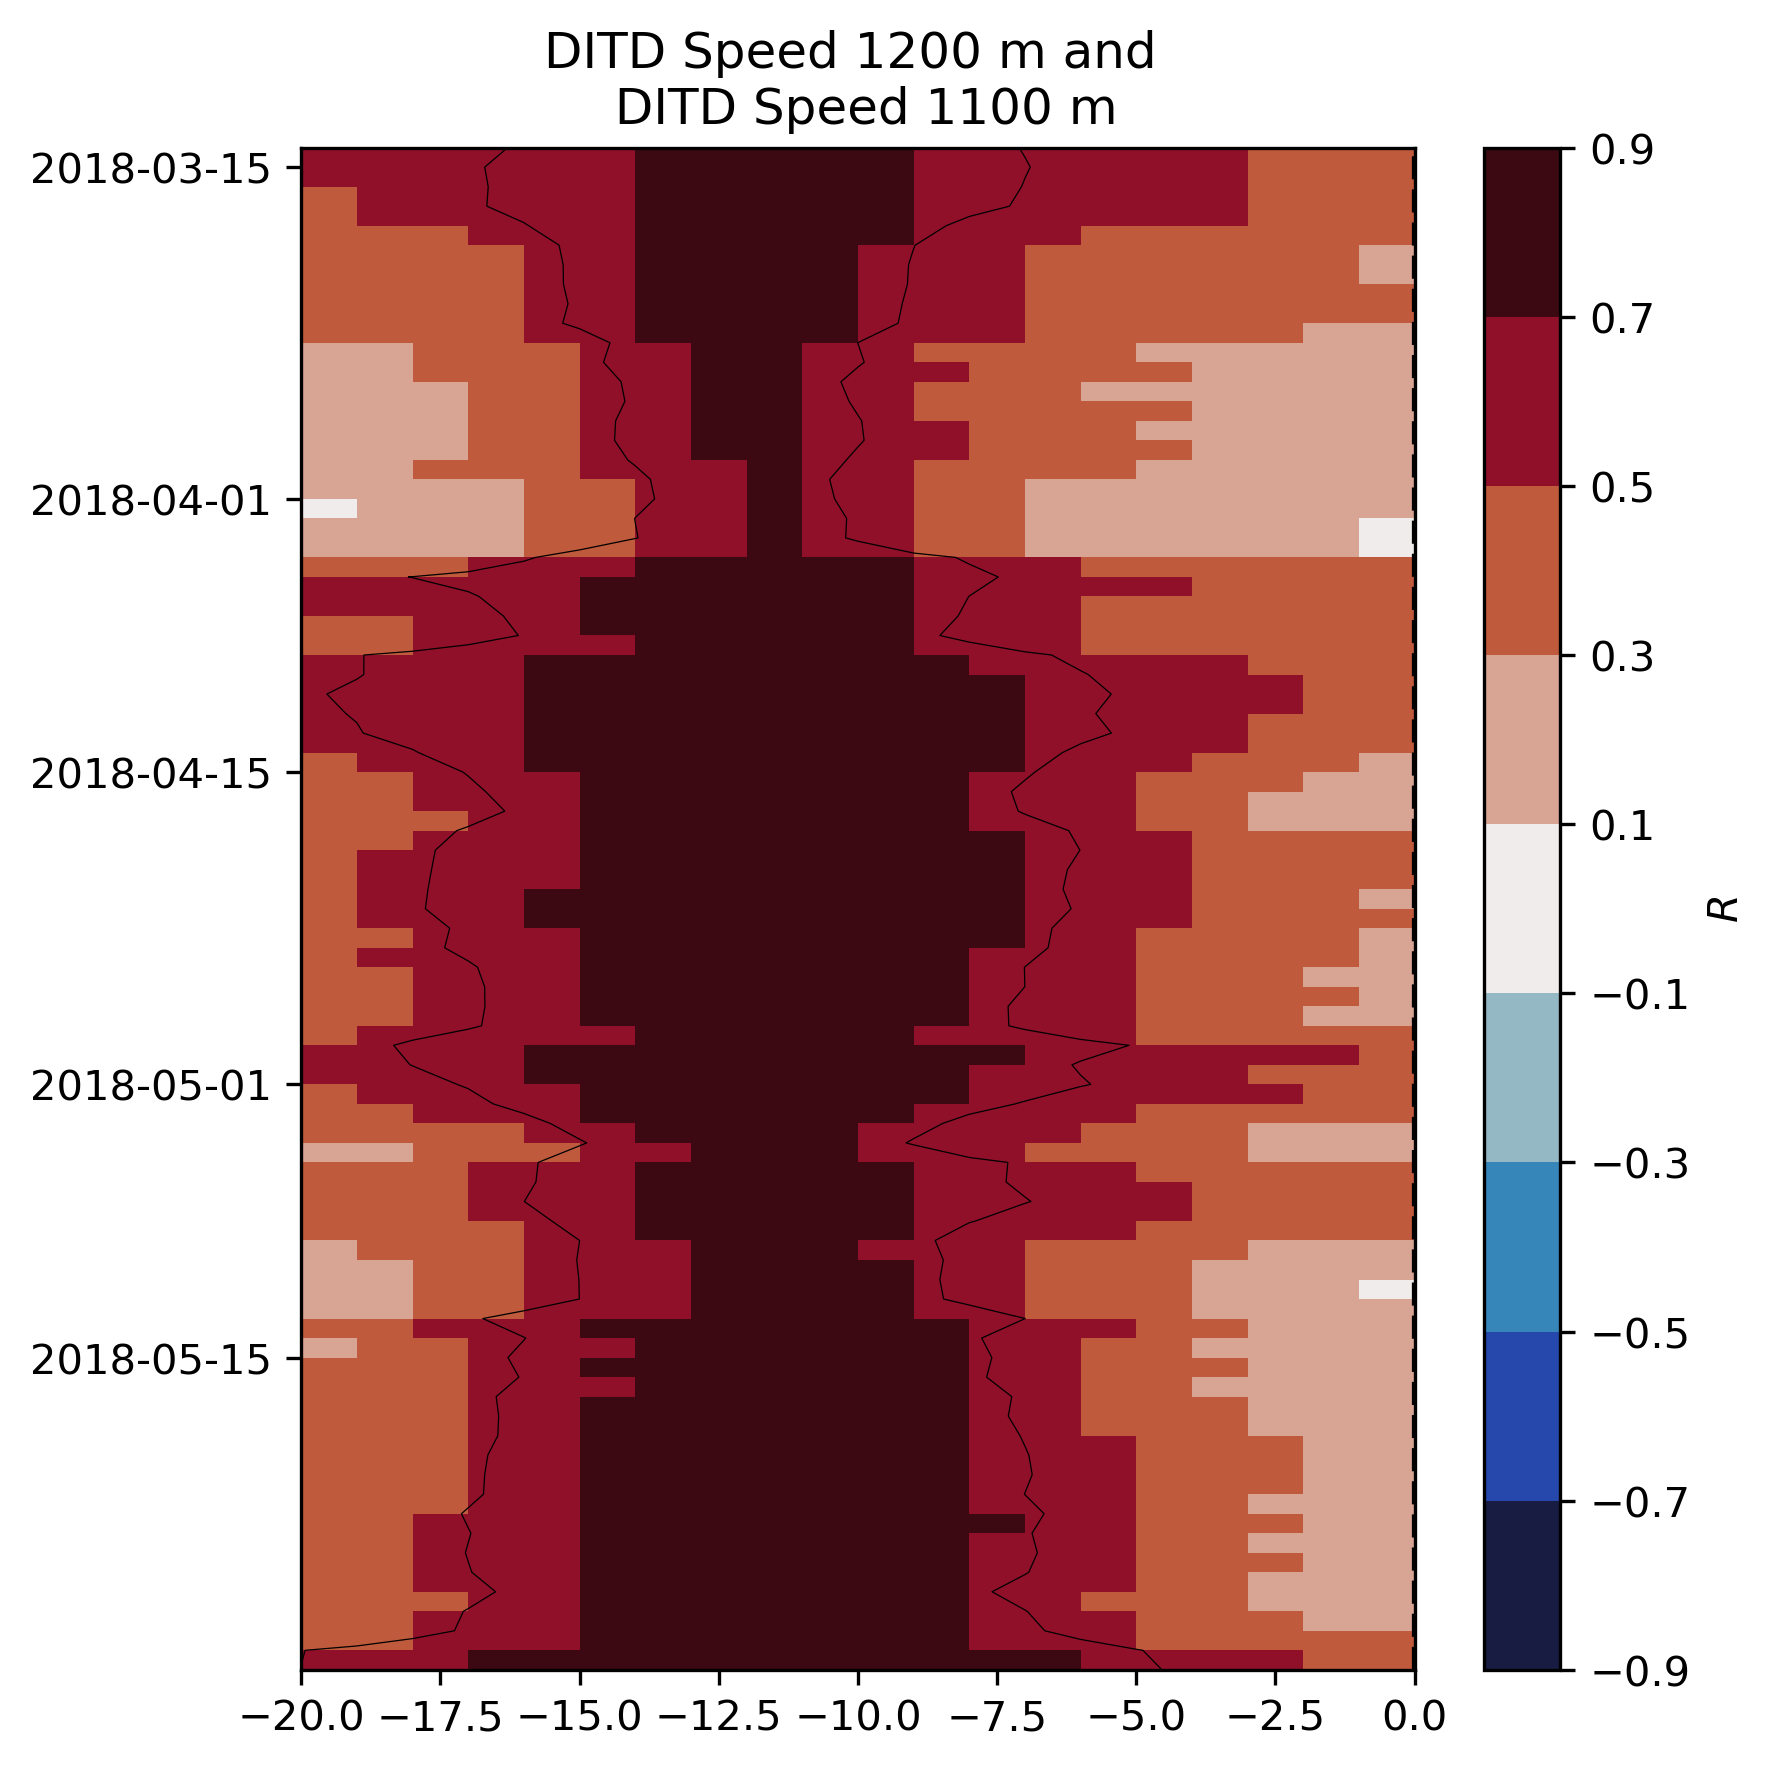

In [73]:
Plot_Corr_Pval(title='DITD Speed 1200 m and \n DITD Speed 1100 m',
               corr = corr,
               pval = pval)

plt.xlim(-20,0)

Text(0.5, 1.0, 'Aligned Time Series')

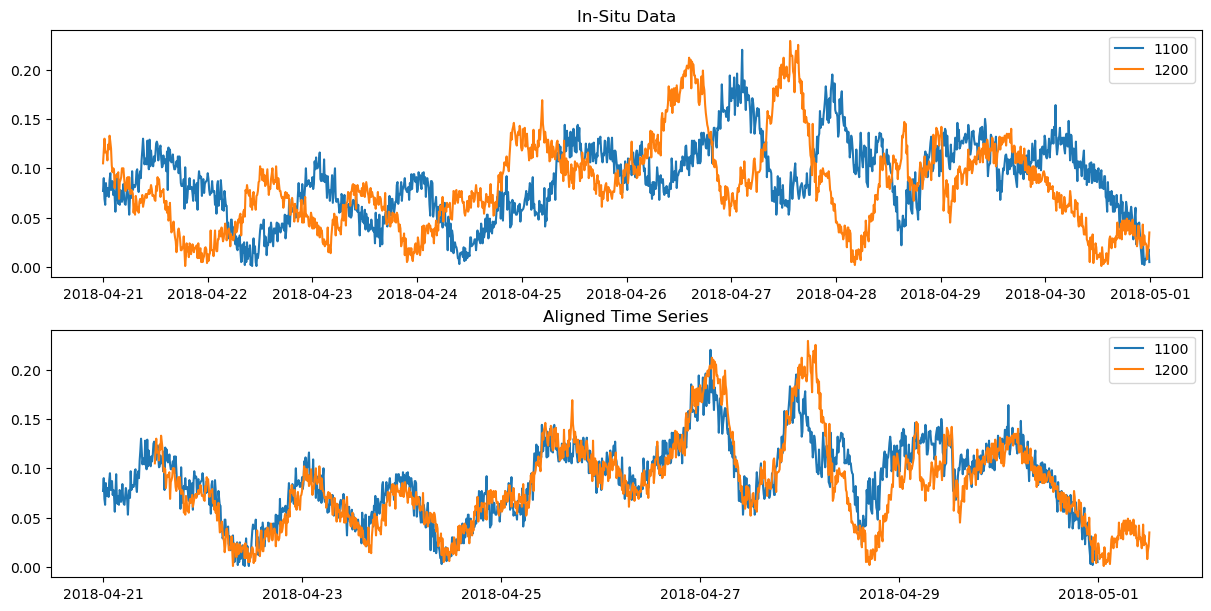

In [75]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1100')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1200')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).speed,label='1100')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time + pd.Timedelta(12.5,'h'),vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).speed,label='1200')
plt.legend()
plt.title('Aligned Time Series')



### Sliding Window Correlation - DITD Zonal Velocity 1200 and 1100 meters 

In [40]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel_ditd.isel(depth=1).east,
                                        ds2 = vel_ditd.isel(depth=0).east,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )


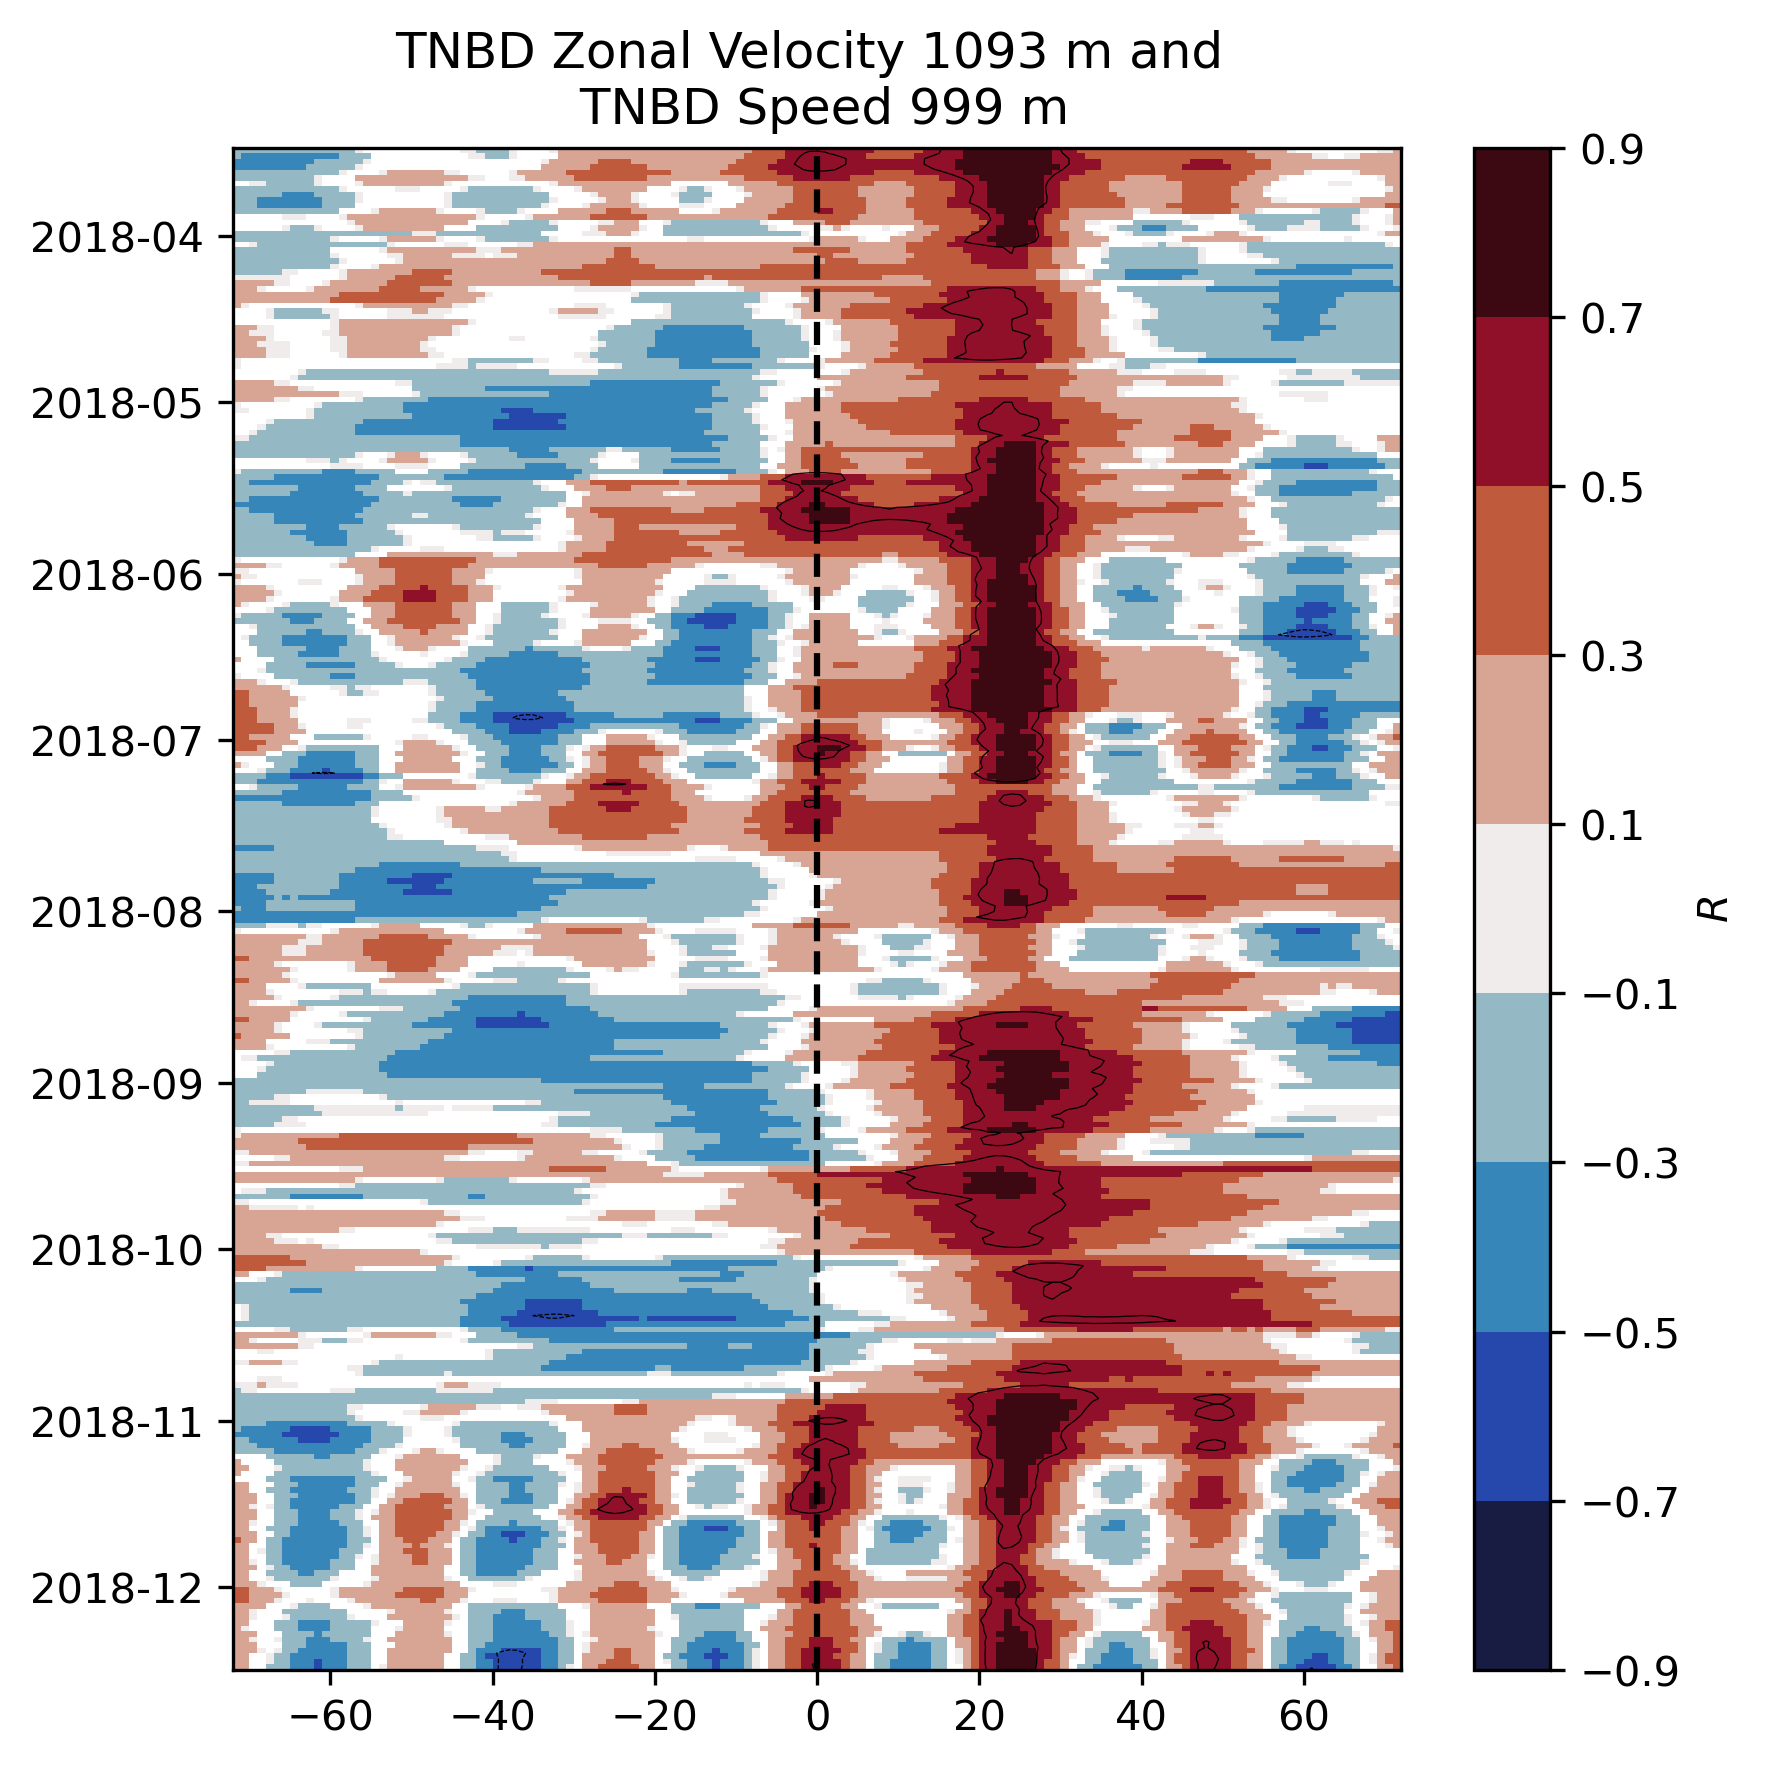

In [41]:
Plot_Corr_Pval(title='DTID Zonal Velocity 1200 m and \n TNBD Speed 1100 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)

Text(0.5, 1.0, 'Aligned Time Series')

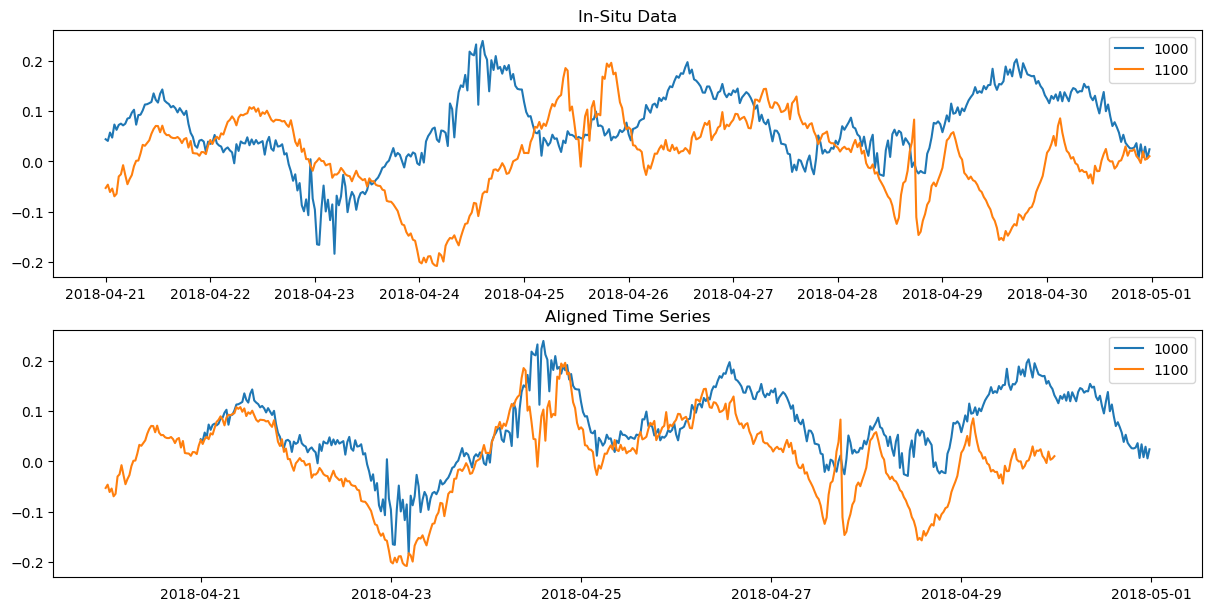

In [42]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('Aligned Time Series')



### Sliding Window Correlation - DITD Meridional Velocity 1200 and 1100 meters

In [ ]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=vel_ditd.isel(depth=1).north,
                                        ds2 = vel_ditd.isel(depth=0).north,
                                        lag_hours=72,
                                        sliding_window=14)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_53634/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )


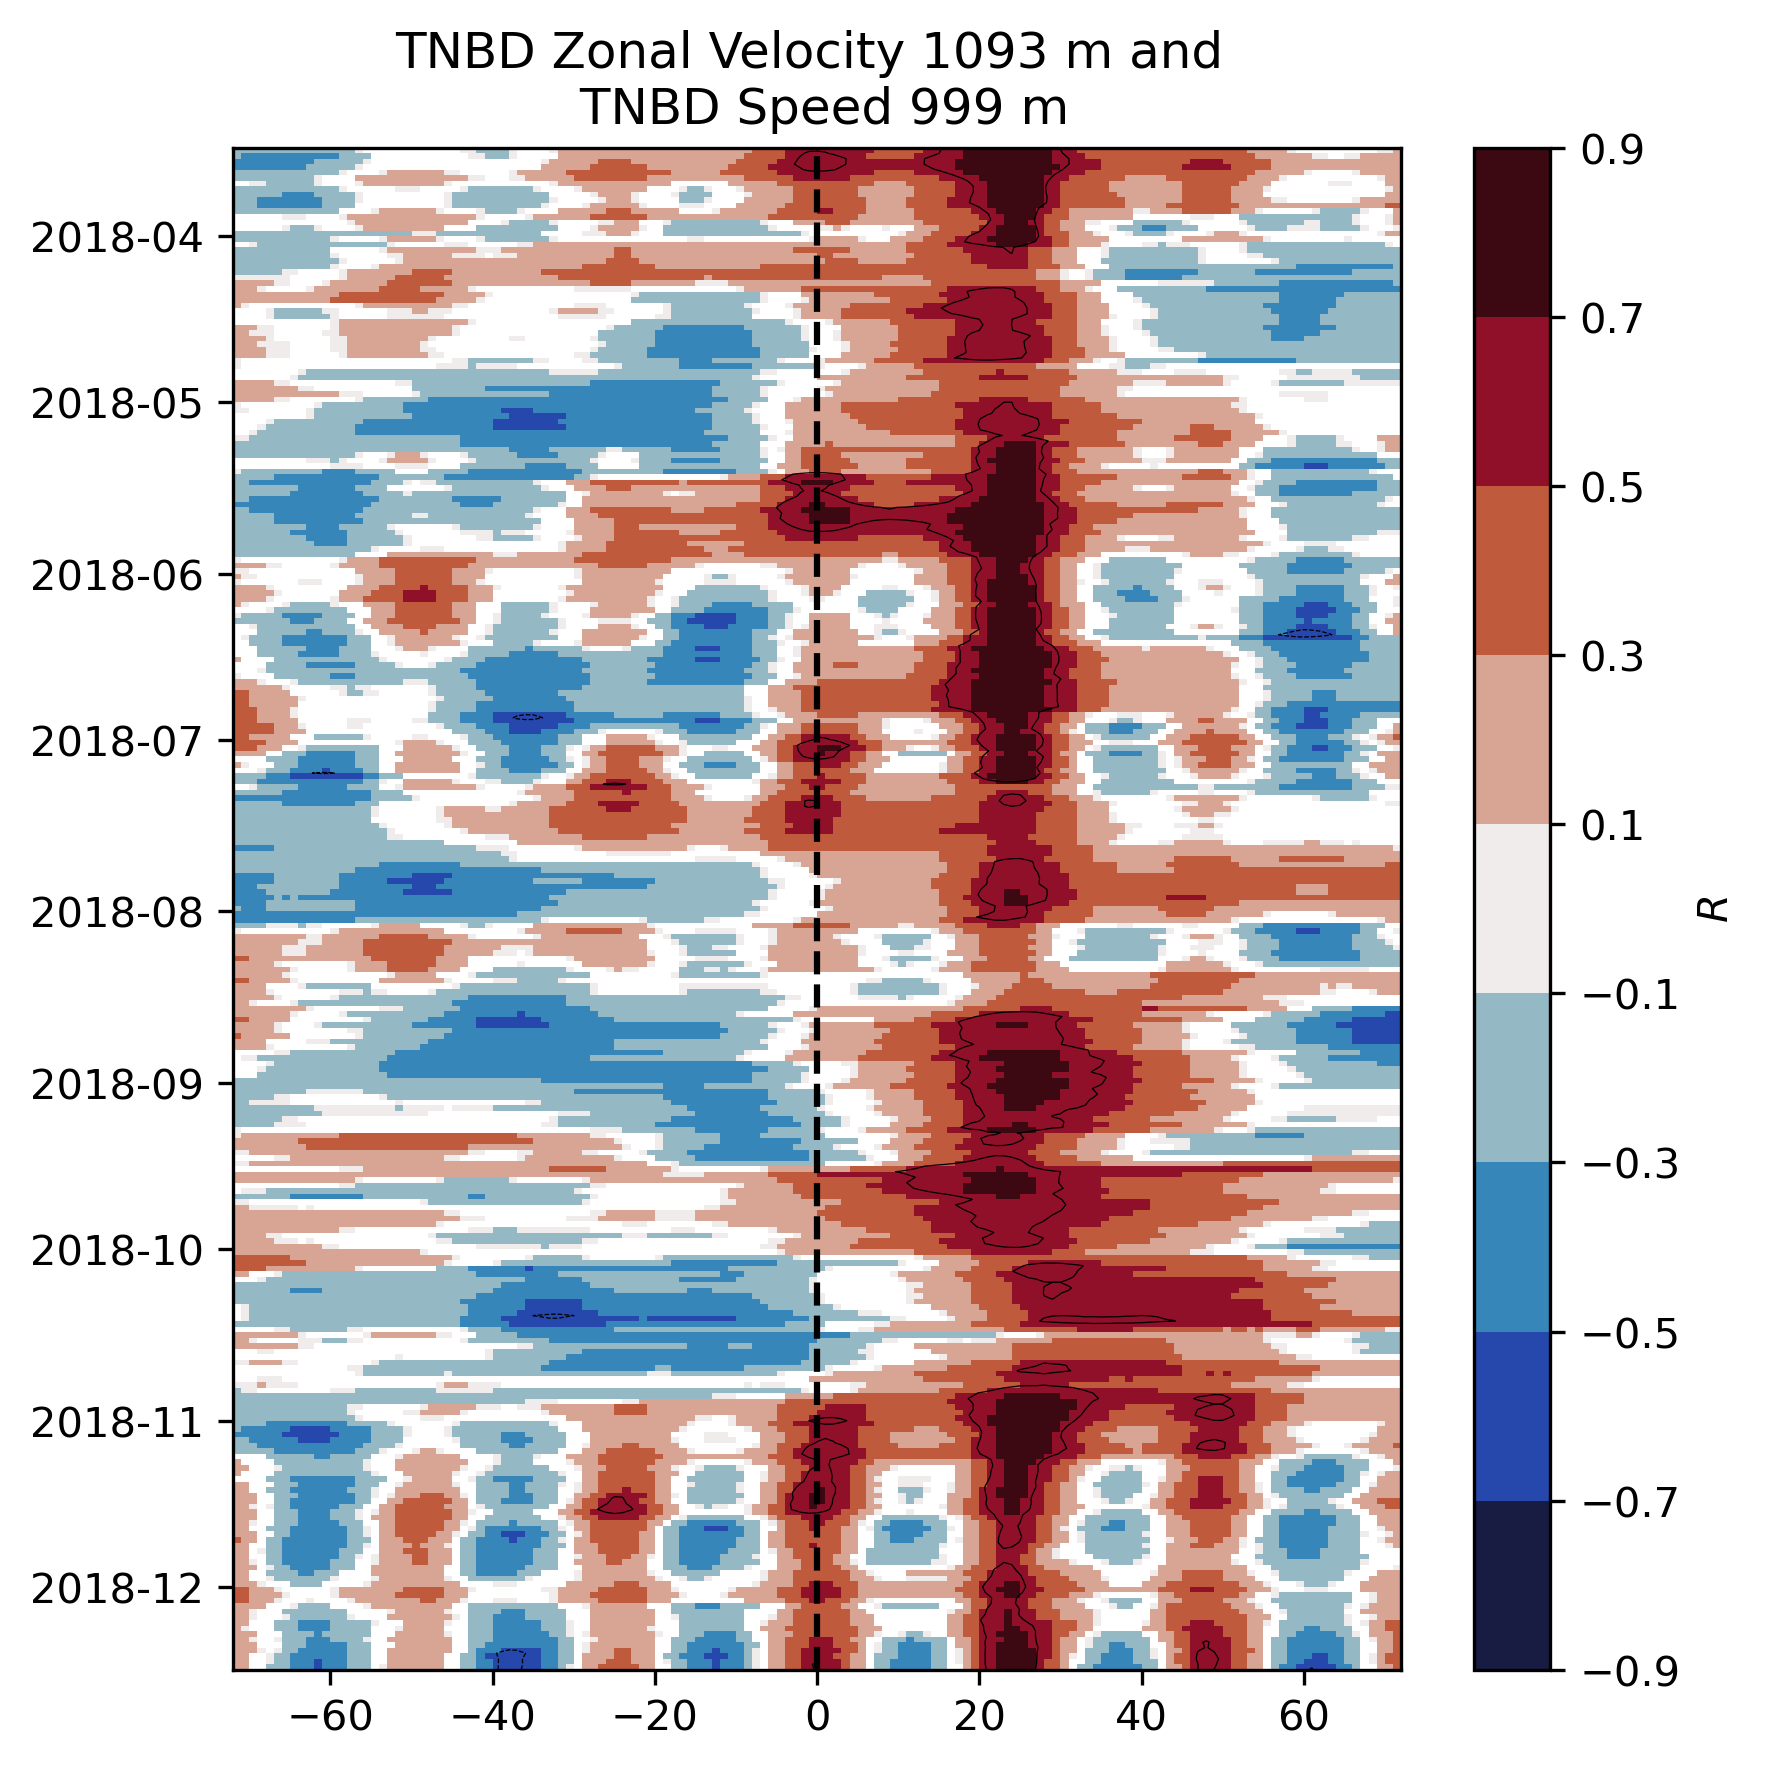

In [41]:
Plot_Corr_Pval(title='DITD Meridional Velocity 1200 m and \n TNBD Speed 1100 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)

Text(0.5, 1.0, 'Aligned Time Series')

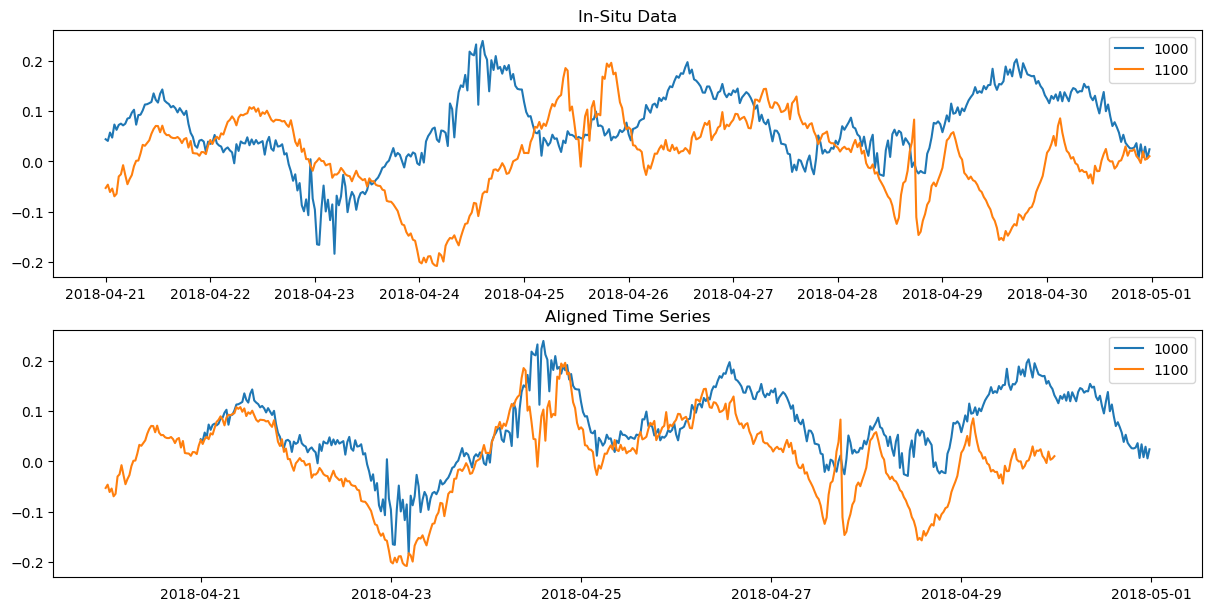

In [42]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('Aligned Time Series')



### Sliding Window Correlation - DITD Speed 1100 m and TNBD Speed 1100 m 

In [44]:
ditd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/DITD_2018_2019/vel_1100.nc')

In [45]:
tnbd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/vel_1100.nc')

In [46]:
# FIX TIME 
# FIX TIME - SUBTRACT 12 hours from upper sensor 
ditd_vel1100['time'] = ditd_vel1100.time - pd.Timedelta(12,'h')
# FIX TIME 
tnbd_vel1100['time'] = tnbd_vel1100.time - pd.Timedelta(24,'h')


In [47]:
tnbd_vel1100 = tnbd_vel1100.sel(time=slice('2018-03-12','2018-12-31'))

In [48]:
tnbd_vel1100

<xarray.Dataset> Size: 2MB
Dimensions:        (time: 28320)
Coordinates:
    index          (time) int64 227kB ...
  * time           (time) datetime64[ns] 227kB 2018-03-12 ... 2018-12-31T23:4...
Data variables:
    east           (time) float64 227kB ...
    north          (time) float64 227kB ...
    up             (time) float64 227kB ...
    pressure_dbar  (time) float64 227kB ...
    pressure       (time) float64 227kB ...
    speed          (time) float64 227kB ...
    direction      (time) float64 227kB ...

In [49]:
ditd_vel1100 = ditd_vel1100.sel(time=slice('2018-03-12','2018-12-31')).resample(time='15min').mean()

In [50]:
ditd_vel1100.time

<xarray.DataArray 'time' (time: 28320)> Size: 227kB
array(['2018-03-12T00:00:00.000000000', '2018-03-12T00:15:00.000000000',
       '2018-03-12T00:30:00.000000000', ..., '2018-12-31T23:15:00.000000000',
       '2018-12-31T23:30:00.000000000', '2018-12-31T23:45:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 227kB 2018-03-12 ... 2018-12-31T23:45:00

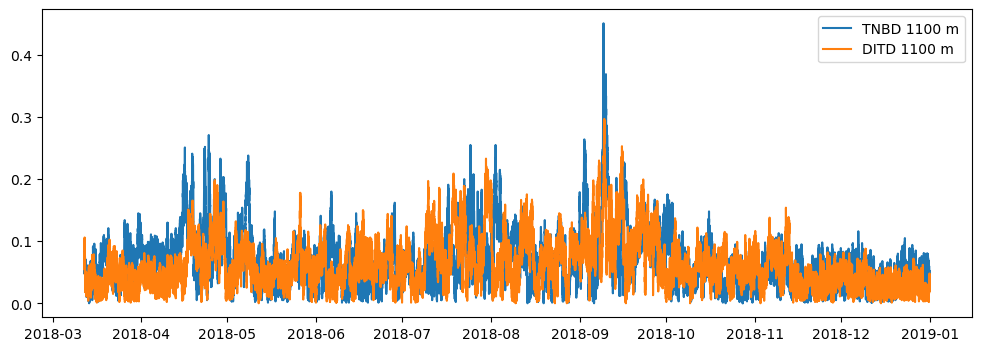

In [54]:
fig = plt.figure(figsize=(12,4))
plt.plot(tnbd_vel1100.time,tnbd_vel1100.speed,label='TNBD 1100 m')
plt.plot(ditd_vel1100.time,ditd_vel1100.speed, label= 'DITD 1100 m')
plt.legend()

In [69]:
tnbd_vel1000.time

<xarray.DataArray 'time' (time: 14256)> Size: 114kB
array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:30:00.000000000',
       '2018-03-13T01:00:00.000000000', ..., '2019-01-03T22:30:00.000000000',
       '2019-01-03T23:00:00.000000000', '2019-01-03T23:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    index    (time) int64 114kB ...
  * time     (time) datetime64[ns] 114kB 2018-03-13 ... 2019-01-03T23:30:00

In [71]:
ditd_vel1100 = ditd_vel1100.resample(time='30min').mean()

In [72]:
# attempt correlation for full time series of velocity data 
corr, pval = sliding_window_correlation(ds1=ditd_vel1100.north,
                                        ds2 = tnbd_vel1000.north,
                                        lag_hours=240,
                                        sliding_window=30)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_21029/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_21029/209530569.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)


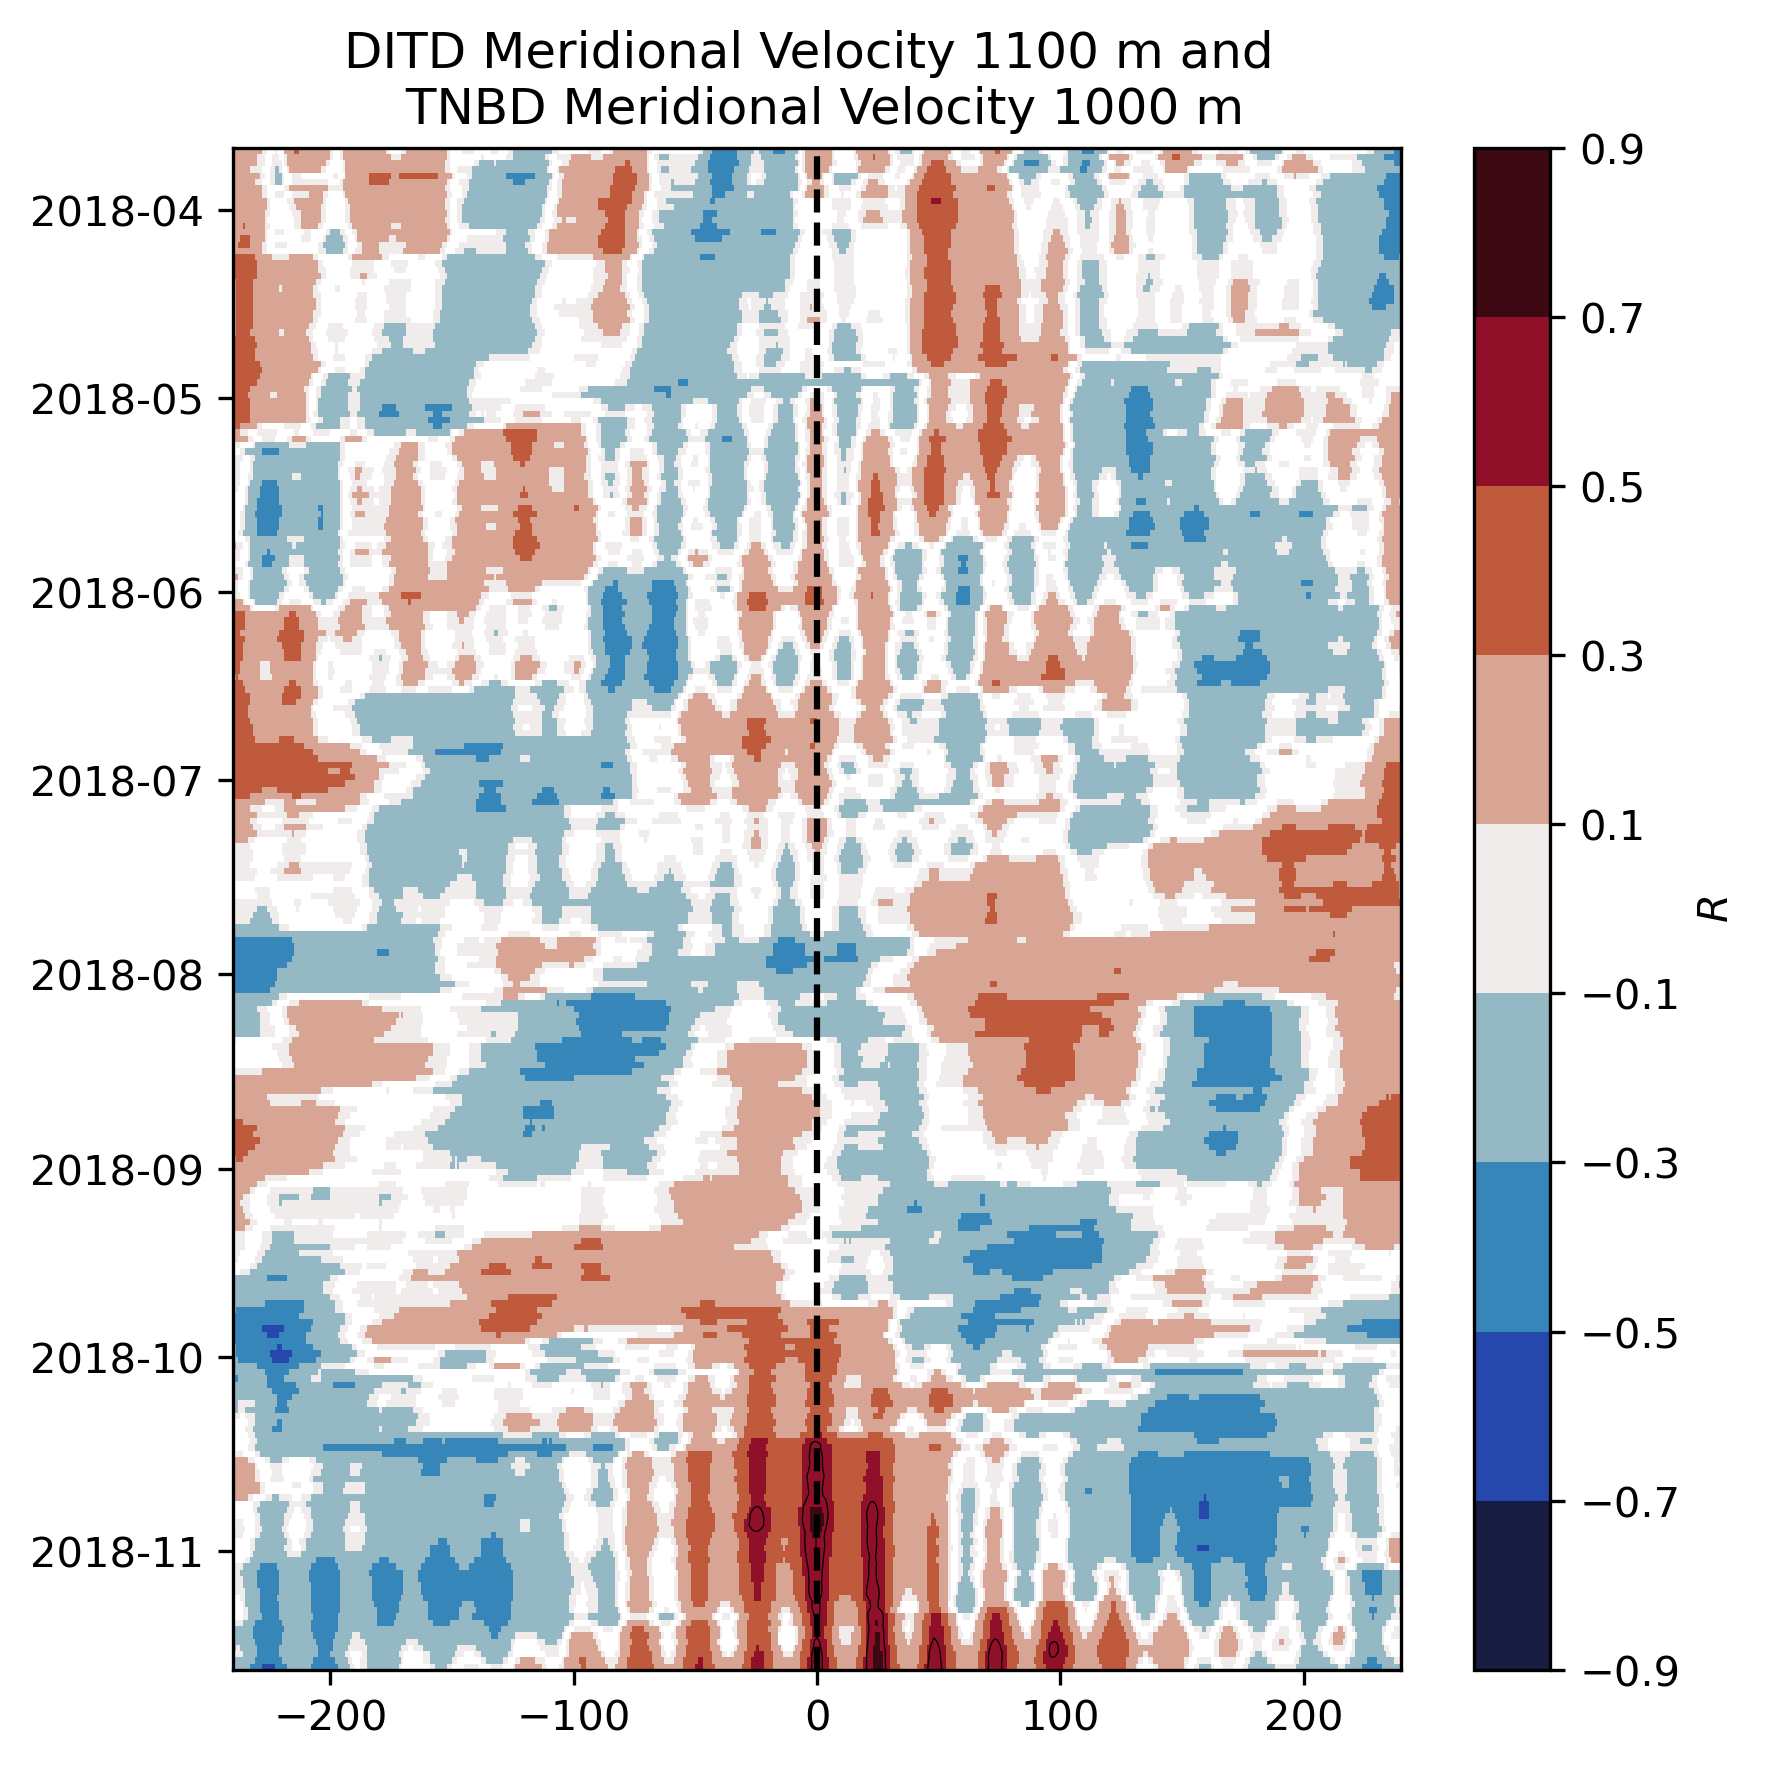

In [73]:
Plot_Corr_Pval(title='DITD Meridional Velocity 1100 m and \n TNBD Meridional Velocity 1000 m',
               corr = corr,
               pval = pval)

# plt.xlim(20,30)
# plt.savefig('DITD_TNBD_meridional_1100_correlation.png')

Text(0.5, 1.0, 'Aligned Time Series')

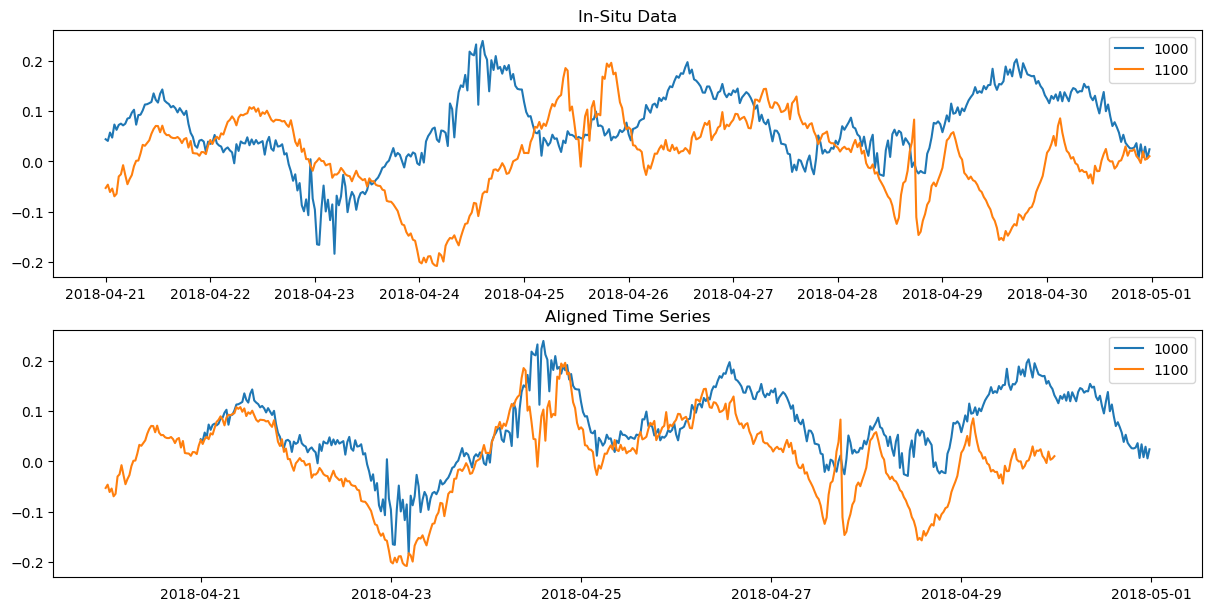

In [42]:
# make some example plots showing in-situ velocity and aligned velocity 
fig = plt.figure(figsize=(12,6),constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('In-Situ Data')

plt.subplot(2,1,2)
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time,vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=0).east,label='1000')
plt.plot(vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).time - pd.Timedelta(24,'h'),vel_ditd.sel(time=slice('2018-04-21','2018-04-30')).isel(depth=1).east,label='1100')
plt.legend()
plt.title('Aligned Time Series')



### Calculate Shear at TNBD 

In [25]:
# zonal shear 
zonal_shear = vel.isel(depth=1).east - vel.isel(depth=0).east

In [26]:
merid_shear = vel.isel(depth=1).north - vel.isel(depth=0).north 

In [27]:
shear = np.sqrt(zonal_shear**2 + merid_shear**2)

In [28]:
zonal_shear

<xarray.DataArray 'east' (time: 14256)> Size: 114kB
array([ 0.01981121,  0.00065476,  0.00289642, ..., -0.0101132 ,
       -0.02241318, -0.01425499])
Coordinates:
    index    (time) int64 114kB 192 193 194 195 196 ... 14444 14445 14446 14447
  * time     (time) datetime64[ns] 114kB 2018-03-13 ... 2019-01-03T23:30:00

Text(0, 0.5, 'Shear [s$^{-1}$]')

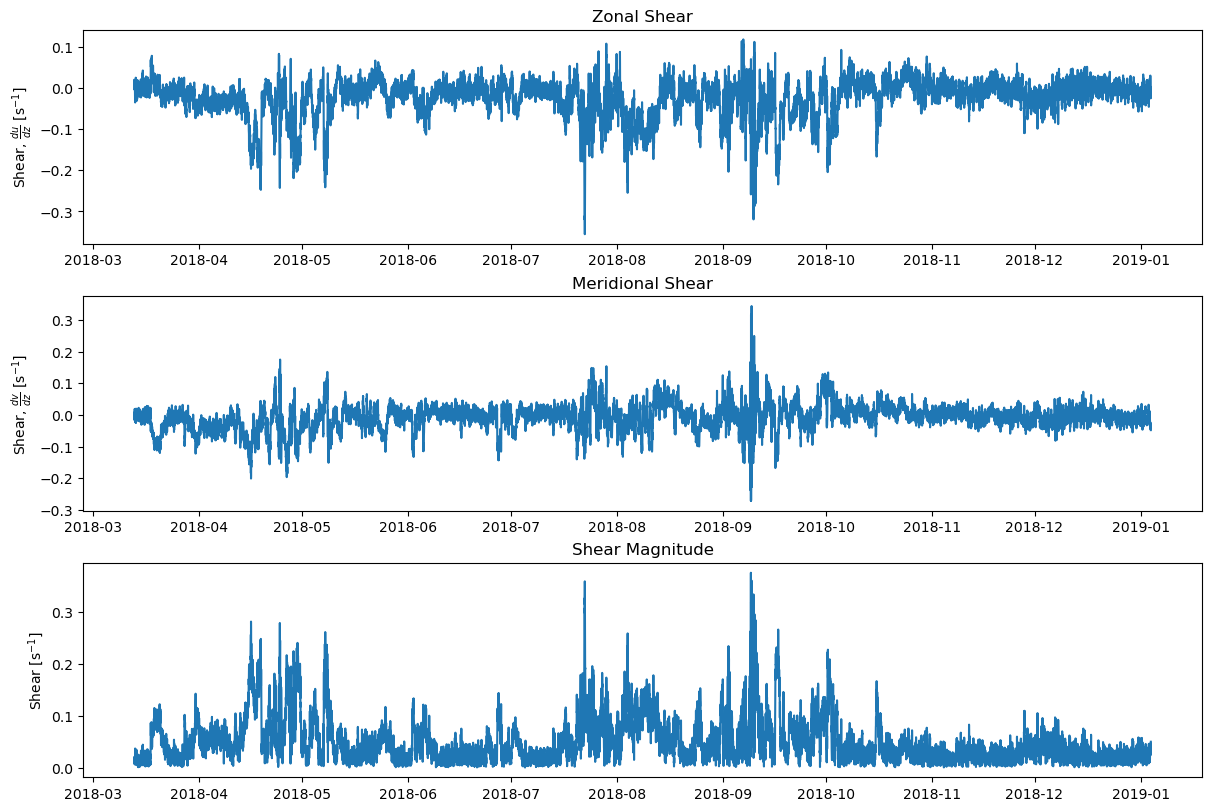

In [38]:
# plot shear 
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time,zonal_shear)
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time,merid_shear)
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time,shear)
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

Look at relationship between presence of HSSW and shear. Look at PIPERS 

Text(0, 0.5, 'Shear [s$^{-1}$]')

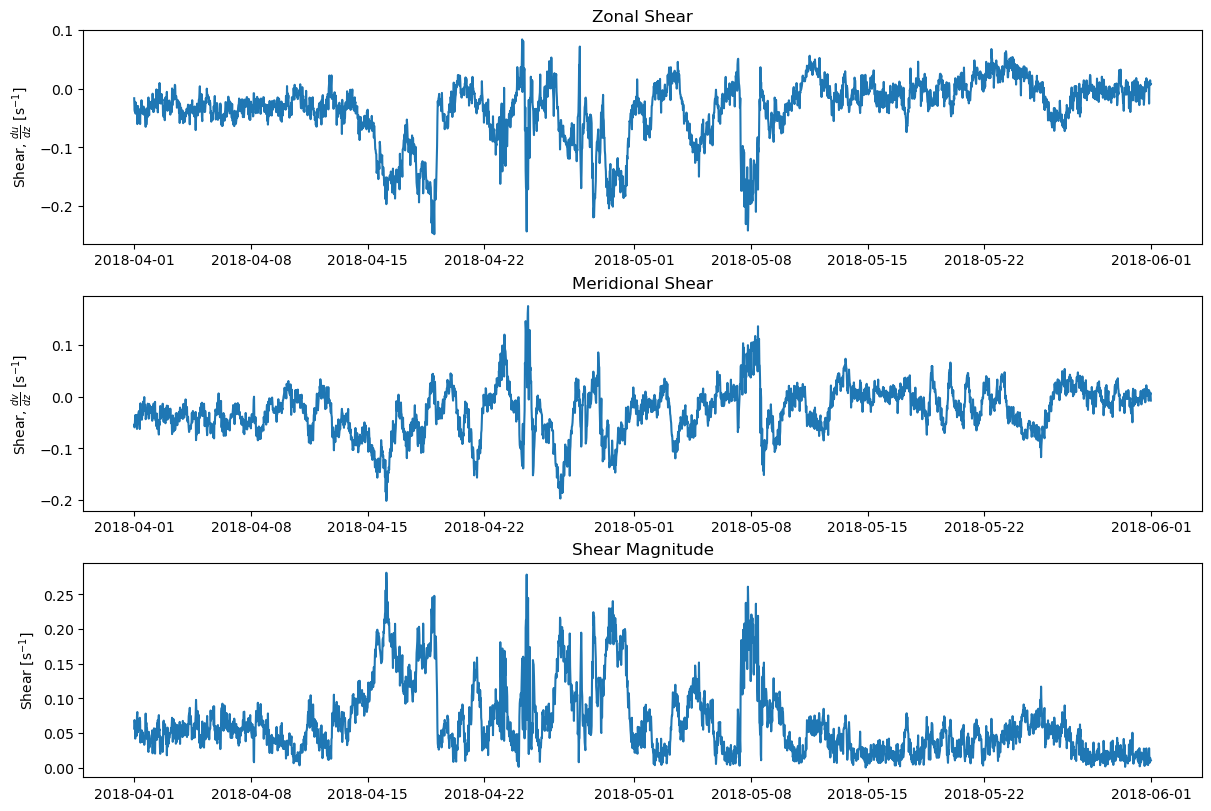

In [39]:
## zoom into subsection of data (April - June)
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time.sel(time=slice('2018-04','2018-05')),zonal_shear.sel(time=slice('2018-04','2018-05')))
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time.sel(time=slice('2018-04','2018-05')),merid_shear.sel(time=slice('2018-04','2018-05')))
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time.sel(time=slice('2018-04','2018-05')),shear.sel(time=slice('2018-04','2018-05')))
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

Text(0, 0.5, 'Shear [s$^{-1}$]')

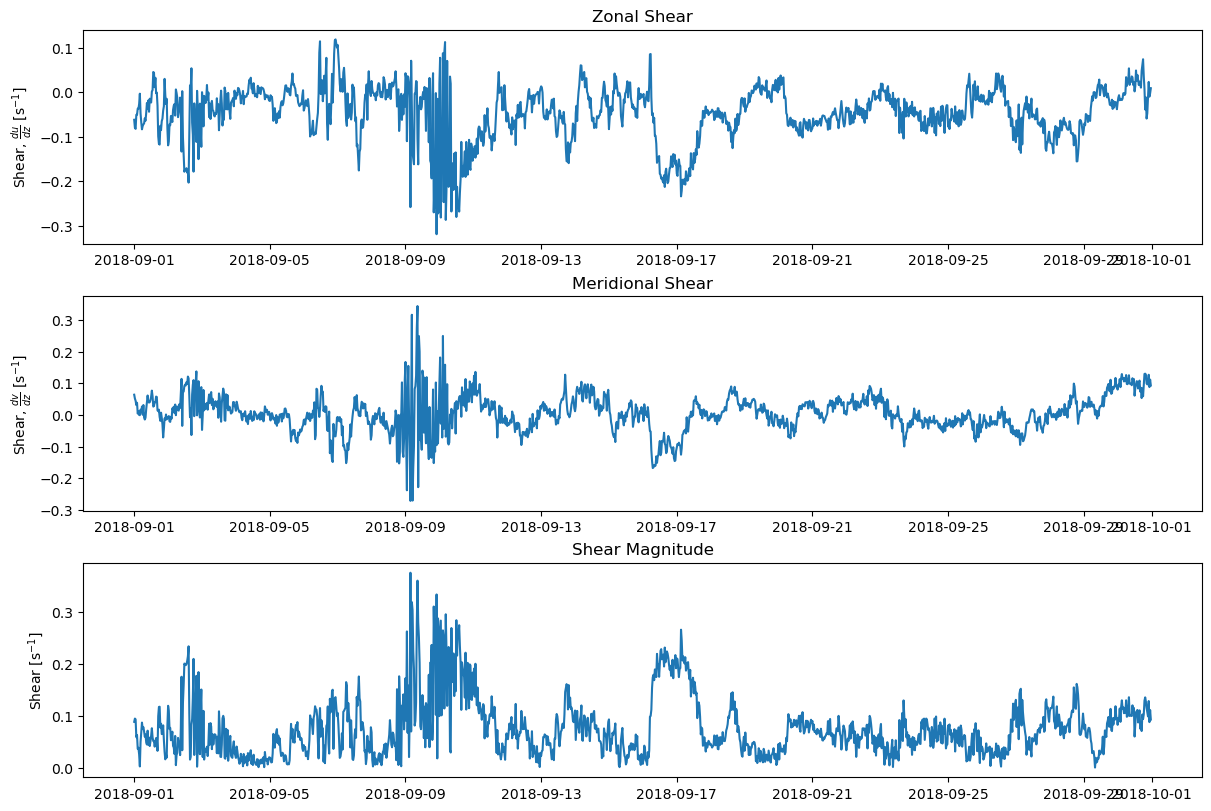

In [40]:
## zoom into subsection of data (September)
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time.sel(time=slice('2018-09-01','2018-09-30')),zonal_shear.sel(time=slice('2018-09-01','2018-09-30')))
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time.sel(time=slice('2018-09-01','2018-09-30')),merid_shear.sel(time=slice('2018-09-01','2018-09-30')))
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time.sel(time=slice('2018-09-01','2018-09-30')),shear.sel(time=slice('2018-09-01','2018-09-30')))
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

### Calculate Shear at DITD 

In [55]:
# zonal shear 
zonal_shear = vel_ditd.isel(depth=1).east - vel_ditd.isel(depth=0).east

In [56]:
merid_shear = vel_ditd.isel(depth=1).north - vel_ditd.isel(depth=0).north 

In [57]:
shear = np.sqrt(zonal_shear**2 + merid_shear**2)

In [58]:
zonal_shear

<xarray.DataArray 'east' (time: 14400)> Size: 115kB
array([ 0.00493101,  0.00596591, -0.01568892, ..., -0.00458664,
       -0.00096585,  0.00106943])
Coordinates:
  * time     (time) datetime64[ns] 115kB 2018-03-11 ... 2018-06-18T23:50:00

Text(0, 0.5, 'Shear [s$^{-1}$]')

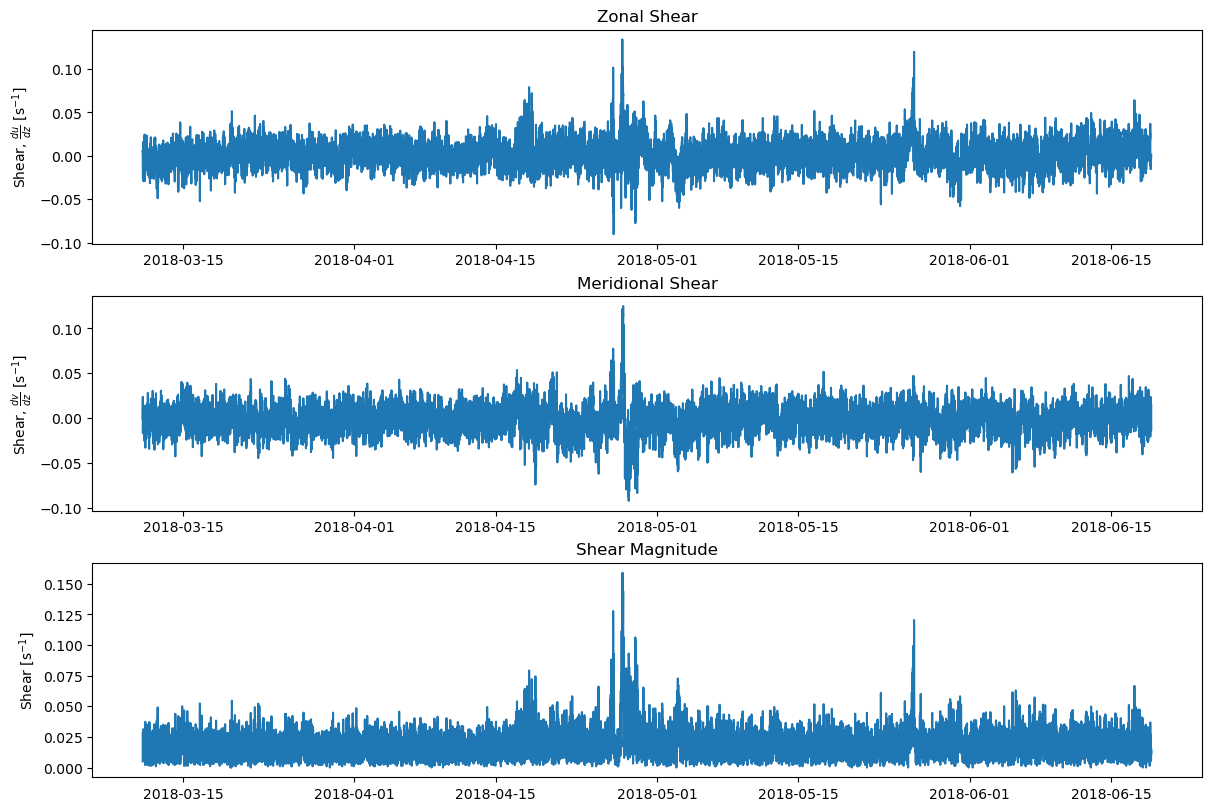

In [59]:
# plot shear 
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time,zonal_shear)
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time,merid_shear)
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time,shear)
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

Text(0, 0.5, 'Shear [s$^{-1}$]')

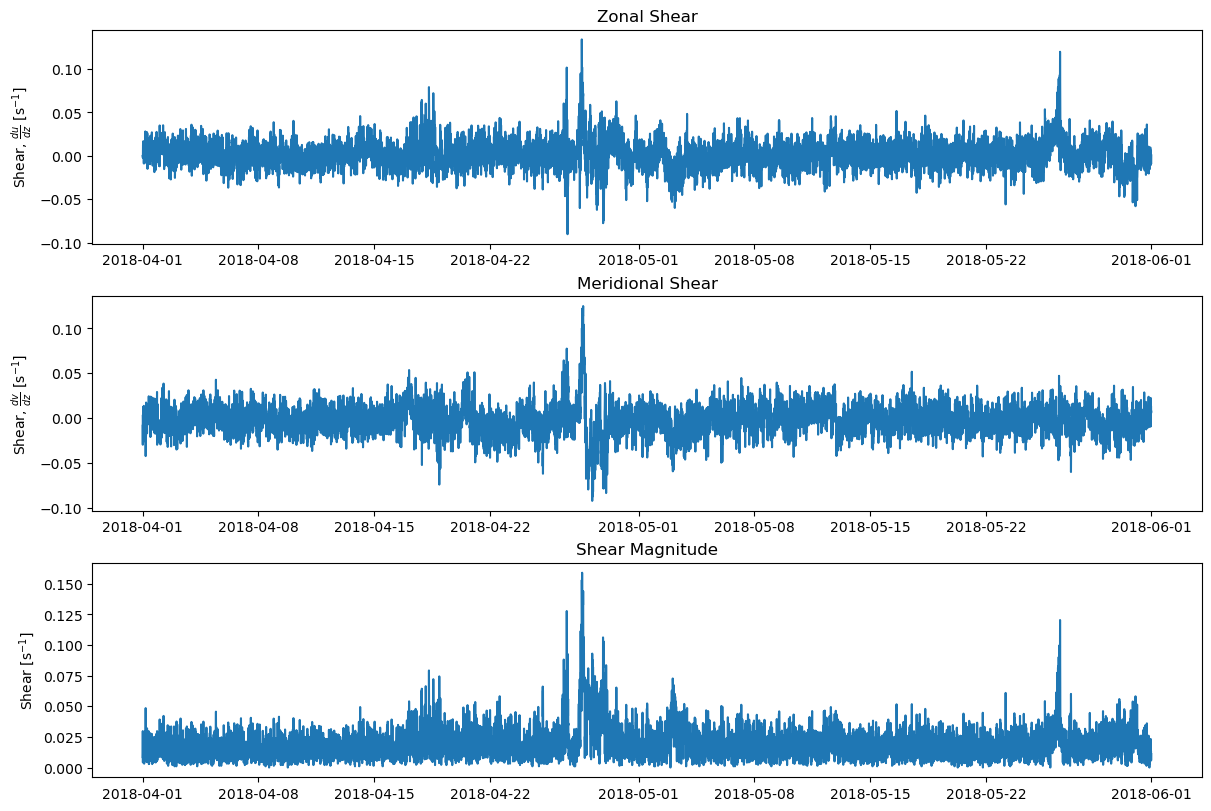

In [60]:
## zoom into subsection of data (April - June)
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time.sel(time=slice('2018-04','2018-05')),zonal_shear.sel(time=slice('2018-04','2018-05')))
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time.sel(time=slice('2018-04','2018-05')),merid_shear.sel(time=slice('2018-04','2018-05')))
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time.sel(time=slice('2018-04','2018-05')),shear.sel(time=slice('2018-04','2018-05')))
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

Text(0, 0.5, 'Shear [s$^{-1}$]')

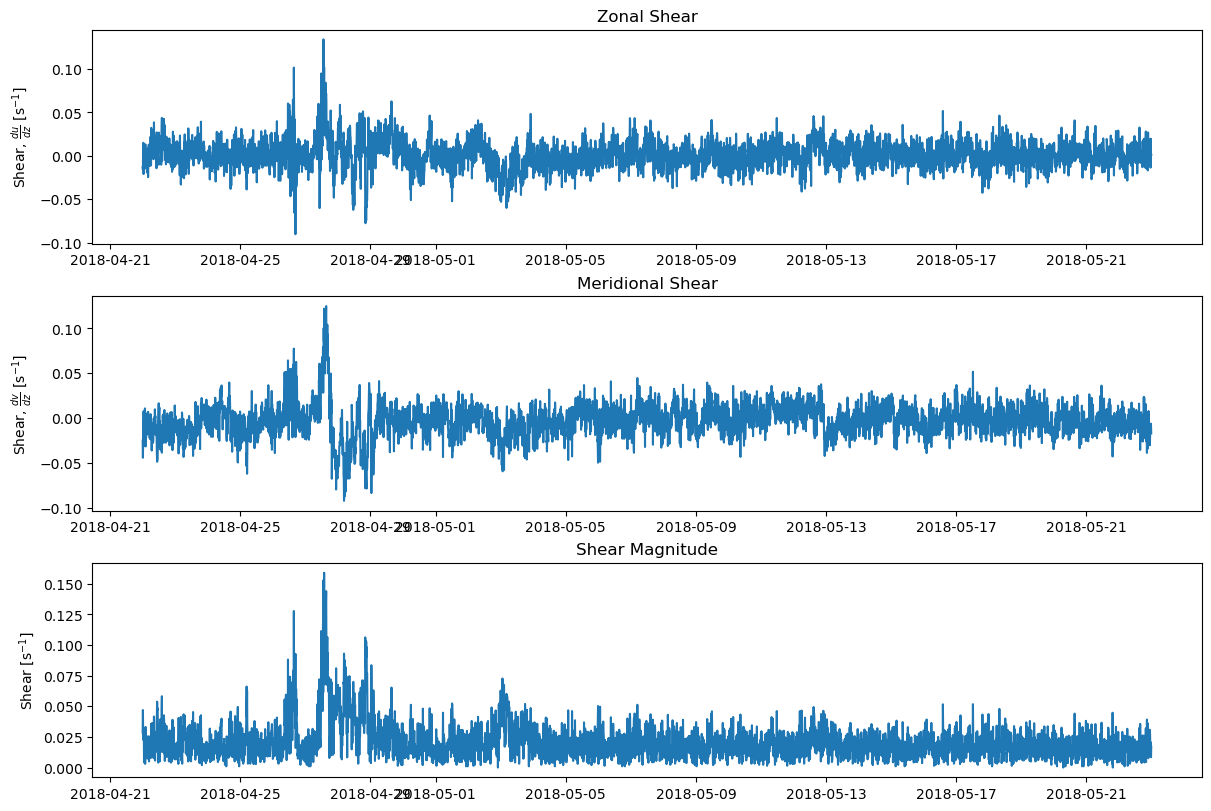

In [61]:
## zoom into subsection of data (September)
fig = plt.figure(figsize=(12,8),constrained_layout=True)

plt.subplot(3,1,1)
plt.plot(zonal_shear.time.sel(time=slice('2018-04-22','2018-05-22')),zonal_shear.sel(time=slice('2018-04-22','2018-05-22')))
plt.title('Zonal Shear')
plt.ylabel(r'Shear, $\frac{du}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,2)
plt.plot(merid_shear.time.sel(time=slice('2018-04-22','2018-05-22')),merid_shear.sel(time=slice('2018-04-22','2018-05-22')))
plt.title('Meridional Shear')
plt.ylabel(r'Shear, $\frac{dv}{dz}$ [s$^{-1}$]')

plt.subplot(3,1,3)
plt.plot(shear.time.sel(time=slice('2018-04-22','2018-05-22')),shear.sel(time=slice('2018-04-22','2018-05-22')))
plt.title('Shear Magnitude')
plt.ylabel(r'Shear [s$^{-1}$]')

### Look at Correlation Between Wind Speed and Salinity - Reproduce Una's Plot 

In [4]:
import os

In [67]:
# load data 
directory = '/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/netCDFs'
varnames=[]
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        file=os.path.splitext(os.path.basename(filename))[0]
        varnames.append(file)

for name in varnames:
    globals()[name] = xr.open_dataset(directory+'/'+name+'.nc')
    print(name);

ice_thickness
awac_storm2
awacbackscatter
continental_withamplitude2
continental_withamplitude
8803_tilt
awac_ice_d1
cm300m
aqd300m2
was
awac_storm3
aws_data
awac_ice
AMSR_subset
aqd370m2
continental3
ldeo_mooring_tempsal_updated
aqd8803_tilt
aqd5388_tilt2
awac_ice10
awac_ice5
cm370m
AMSR_bremen_subset
aqd5388_tilt3
awac_ice4
tke85m_data
aqd230m
awaccur
continental2
tnb_coare_winter
waves
aqd200m
continental5
modisaqua_timeseries
awac_ice7
awac_storm
aqd5388_tilt4
cm230m
continental
seabirds
awac_ice3
aqd5388_tilt5
modisaqua_timeseries2
awac_ice2
tke50m_data
aqd5388_tilt
continental4
SBE4
aqd370m
awac_ice6
was2
modisterra_timeseries
tnb_coare_winter2
awac_ice_d2
aqd300m
awac_ice9
SBE
aqd230m2
awac_amp
awac_ice8
aws_data2
awac_vel
tnb_coare_winter3


In [68]:
# load data 
sbe = ldeo_mooring_tempsal_updated


In [69]:
aws_data = aws_data.assign(wspd = aws_data.wspd.dropna(dim='time'))

In [70]:
aws_data.wspd

<xarray.DataArray 'wspd' (time: 69838)> Size: 559kB
array([ 2.5999999,  2.7      ,  2.7      , ..., 19.6000004, 20.7999992,
       20.       ])
Coordinates:
  * time     (time) datetime64[ns] 559kB 2017-01-01T00:10:00 ... 2018-04-30T2...

In [71]:
sal = sbe.isel(depth=0).practical_salinity

In [72]:
wspd = aws_data.wspd

In [73]:
sal = sal.resample(time='10min').mean().sel(time=slice('2017-02-02','2018-03-04'))

In [74]:
# select same time in wspd data 
wspd = wspd.sel(time=slice('2017-02-02','2018-03-04'))

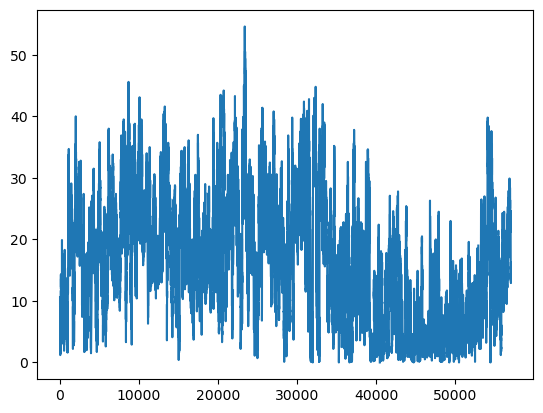

In [76]:
plt.plot(wspd)

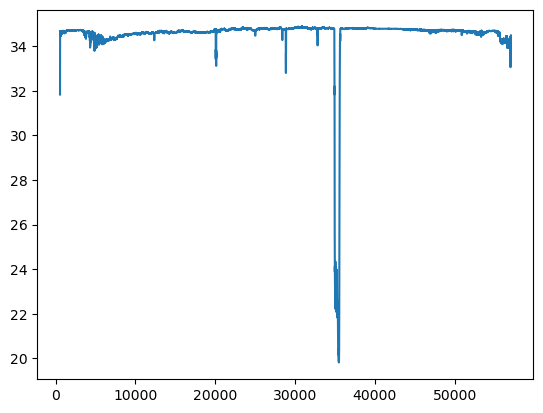

In [75]:
plt.plot(sal)

In [13]:
wspd.time

<xarray.DataArray 'time' (time: 57024)> Size: 456kB
array(['2017-02-02T00:00:00.000000000', '2017-02-02T00:10:00.000000000',
       '2017-02-02T00:20:00.000000000', ..., '2018-03-04T23:30:00.000000000',
       '2018-03-04T23:40:00.000000000', '2018-03-04T23:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 456kB 2017-02-02 ... 2018-03-04T23:50:00

In [14]:
sal.time

<xarray.DataArray 'time' (time: 57024)> Size: 456kB
array(['2017-02-02T00:00:00.000000000', '2017-02-02T00:10:00.000000000',
       '2017-02-02T00:20:00.000000000', ..., '2018-03-04T23:30:00.000000000',
       '2018-03-04T23:40:00.000000000', '2018-03-04T23:50:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    depth    int32 4B 47
  * time     (time) datetime64[ns] 456kB 2017-02-02 ... 2018-03-04T23:50:00

In [15]:
wspd = wspd.dropna(dim='time')

In [16]:
sal = sal.sel(time=wspd.time)

In [17]:
sal = sal.dropna(dim='time')

In [18]:
wspd = wspd.sel(time=sal.time)

In [19]:
time = wspd.time.data

In [20]:
ds = xr.Dataset(
    data_vars = dict(
        wspd=(['time'],wspd.data),
        sal = (['time'],sal.data)
    ),
    coords = dict(time=time))

In [21]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:  (time: 56248)
Coordinates:
  * time     (time) datetime64[ns] 450kB 2017-02-05T20:30:00 ... 2018-03-04T2...
Data variables:
    wspd     (time) float64 450kB 14.4 14.2 14.1 14.5 ... 14.5 12.9 16.3 15.3
    sal      (time) float64 450kB 31.83 34.43 34.43 34.44 ... 34.37 34.47 34.48

In [25]:
ds1 = ds.wspd
ds2 = ds.sal

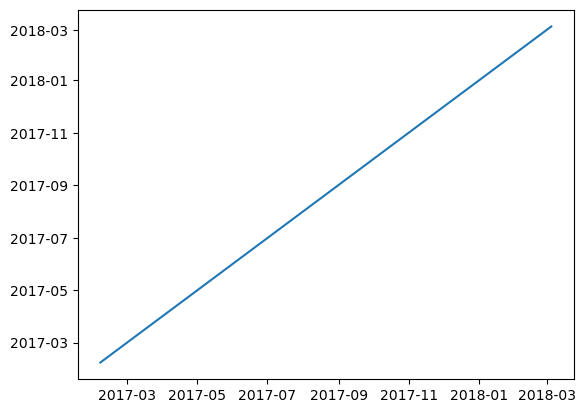

In [26]:
plt.plot(ds1.time,ds2.time)

In [27]:
ds1

<xarray.DataArray 'wspd' (time: 56248)> Size: 450kB
array([14.3999996, 14.1999998, 14.1000004, ..., 12.8999996, 16.2999992,
       15.3000002])
Coordinates:
  * time     (time) datetime64[ns] 450kB 2017-02-05T20:30:00 ... 2018-03-04T2...

In [28]:
ds2

<xarray.DataArray 'sal' (time: 56248)> Size: 450kB
array([31.83179922, 34.43474203, 34.43359532, ..., 34.36515975,
       34.46941697, 34.48310399])
Coordinates:
  * time     (time) datetime64[ns] 450kB 2017-02-05T20:30:00 ... 2018-03-04T2...

In [46]:
lag_hours = 200
sliding_window = 30*24     #hours

In [48]:
# calculate when correlation analysis should start 
start = (ds1.time[0] + pd.Timedelta(lag_hours,'h'))
end = (ds1.time[-1] - pd.Timedelta(lag_hours,'h'))

In [49]:
start

<xarray.DataArray 'time' ()> Size: 8B
array('2017-02-14T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-05T20:30:00

In [50]:
end

<xarray.DataArray 'time' ()> Size: 8B
array('2018-02-24T15:50:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2018-03-04T23:50:00

In [51]:
sliding_window_indice = np.arange(-lag_hours,lag_hours+1,1)

In [52]:
sliding_window_indice

array([-200, -199, -198, -197, -196, -195, -194, -193, -192, -191, -190,
       -189, -188, -187, -186, -185, -184, -183, -182, -181, -180, -179,
       -178, -177, -176, -175, -174, -173, -172, -171, -170, -169, -168,
       -167, -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
       -156, -155, -154, -153, -152, -151, -150, -149, -148, -147, -146,
       -145, -144, -143, -142, -141, -140, -139, -138, -137, -136, -135,
       -134, -133, -132, -131, -130, -129, -128, -127, -126, -125, -124,
       -123, -122, -121, -120, -119, -118, -117, -116, -115, -114, -113,
       -112, -111, -110, -109, -108, -107, -106, -105, -104, -103, -102,
       -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,  -93,  -92,  -91,
        -90,  -89,  -88,  -87,  -86,  -85,  -84,  -83,  -82,  -81,  -80,
        -79,  -78,  -77,  -76,  -75,  -74,  -73,  -72,  -71,  -70,  -69,
        -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,  -60,  -59,  -58,
        -57,  -56,  -55,  -54,  -53,  -52,  -51,  -

In [53]:
# calculate sliding window start and stop 
window_stop = start + pd.Timedelta(sliding_window,'hr')

In [54]:
window_stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-16T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-05T20:30:00

In [55]:
(end-window_stop).values.astype('timedelta64[D]').astype('int')

345

In [59]:
nhours = (end-window_stop).values.astype('timedelta64[h]').astype('int')

In [60]:
# # calculate sliding window start and stop 
# window_stop = start + pd.Timedelta(sliding_window,'hr')

# # calculate ndays
# ndays = (end-window_stop).values.astype('timedelta64[D]').astype('int')

# calculate correlation stuff 
corr = []
pval = []

In [36]:
ndays

345

In [61]:
window_stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-16T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-05T20:30:00

In [38]:
# test one window to see what happens with slicing 
start = (ds1.time[0] + pd.Timedelta(lag_hours,'h')) + pd.Timedelta(1,'d')
stop = (ds1.time[0] + pd.Timedelta(lag_hours,'h') + pd.Timedelta(sliding_window,'d')) + pd.Timedelta(1,'d')

In [39]:
start

<xarray.DataArray 'time' ()> Size: 8B
array('2017-02-15T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-05T20:30:00

In [40]:
stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-17T04:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-05T20:30:00

In [41]:
sliding_start = ds1.sel(time=start).time + pd.Timedelta(sliding_window_indice[0],'hr')
sliding_stop = ds1.sel(time=stop).time + pd.Timedelta(sliding_window_indice[0],'hr')

In [42]:
sliding_start

<xarray.DataArray 'time' ()> Size: 8B
array('2017-02-06T20:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-02-15T04:30:00

In [43]:
sliding_stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-08T20:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-03-17T04:30:00

In [44]:
ds2.sel(time=slice(start,stop))

<xarray.DataArray 'sal' (time: 4311)> Size: 34kB
array([34.69040543, 34.67865746, 34.68091741, ..., 34.2032369 ,
       34.20543052, 34.20663301])
Coordinates:
  * time     (time) datetime64[ns] 34kB 2017-02-15T04:30:00 ... 2017-03-17T04...

In [45]:
ds1.sel(time=slice(sliding_start,sliding_stop))

<xarray.DataArray 'wspd' (time: 4309)> Size: 34kB
array([ 9.8999996,  9.8000002, 10.6999998, ..., 32.7000008, 32.4000015,
       29.       ])
Coordinates:
  * time     (time) datetime64[ns] 34kB 2017-02-06T20:30:00 ... 2017-03-08T20...

In [62]:
for i in np.arange(0,nhours,1):
    start = (ds1.time[0] + pd.Timedelta(lag_hours,'h')) + pd.Timedelta(i,'h')
    stop = (ds1.time[0] + pd.Timedelta(lag_hours,'h') + pd.Timedelta(sliding_window,'h')) + pd.Timedelta(i,'h') 
    
    for hrs in range(len(sliding_window_indice)):
        
        sliding_start = ds1.sel(time=start).time + pd.Timedelta(sliding_window_indice[hrs],'hr')
        sliding_stop = ds1.sel(time=stop).time + pd.Timedelta(sliding_window_indice[hrs],'hr')
        
        x = signal.detrend(ds2.sel(time=slice(start,stop)))
        y = signal.detrend(ds1.sel(time=slice(sliding_start,sliding_stop)))
    
        r, p = scipy.stats.pearsonr(x, y)
        corr.append(r)
        pval.append(p)

ValueError: `x` and `y` must have the same length along `axis`.

In [65]:
len(x)

4310

In [66]:
len(y)

4309

In [125]:
sliding_start

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-03-09T08:00:00
    depth    int32 4B 47

In [126]:
sliding_stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-31T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-04-08T08:00:00
    depth    int32 4B 47

In [127]:
start

<xarray.DataArray 'time' ()> Size: 8B
array('2017-03-09T08:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-03-01
    depth    int32 4B 47

In [128]:
stop

<xarray.DataArray 'time' ()> Size: 8B
array('2017-04-08T08:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2017-03-01
    depth    int32 4B 47

In [129]:
len(x)

4308

In [130]:
len(y)

4310

In [149]:
print(ds1.time[:5].values)

['2017-03-01T00:00:00.000000000' '2017-03-01T00:10:00.000000000'
 '2017-03-01T00:20:00.000000000' '2017-03-01T00:30:00.000000000'
 '2017-03-01T00:40:00.000000000']


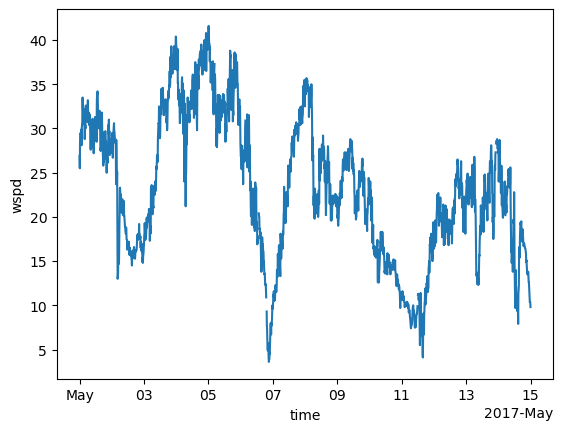

In [77]:
wspd.sel(time=slice('2017-05-01','2017-05-14')).plot()

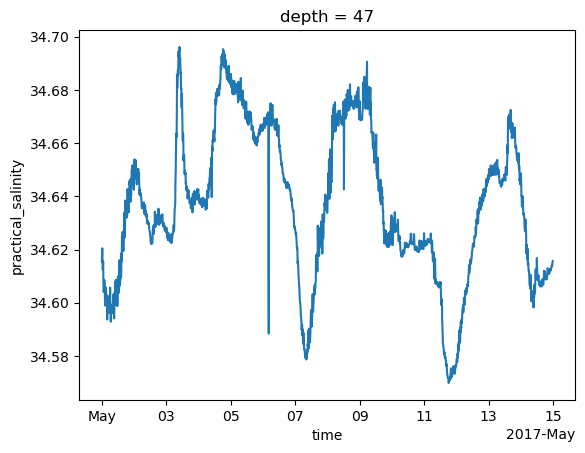

In [78]:
sal.sel(time=slice('2017-05-01','2017-05-14')).plot()

In [86]:
sal = sal.sel(time=slice('2017-03','2017-12'))

In [87]:
wspd = wspd.sel(time=slice('2017-03','2017-12'))

In [93]:
sal = sal.interpolate_na(dim='time')

In [94]:
wspd = wspd.interpolate_na(dim='time')

In [96]:
# now we can do correlation analysis since wind speed and sal data are aligned 

corr, pval = sliding_window_correlation(ds1=wspd,
                                        ds2 = sal,
                                        lag_hours=200,
                                        sliding_window=30)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_14391/209530569.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm )
/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_14391/209530569.py:22: UserWarning: No contour levels were found within the data range.
  plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)


(-50.0, 0.0)

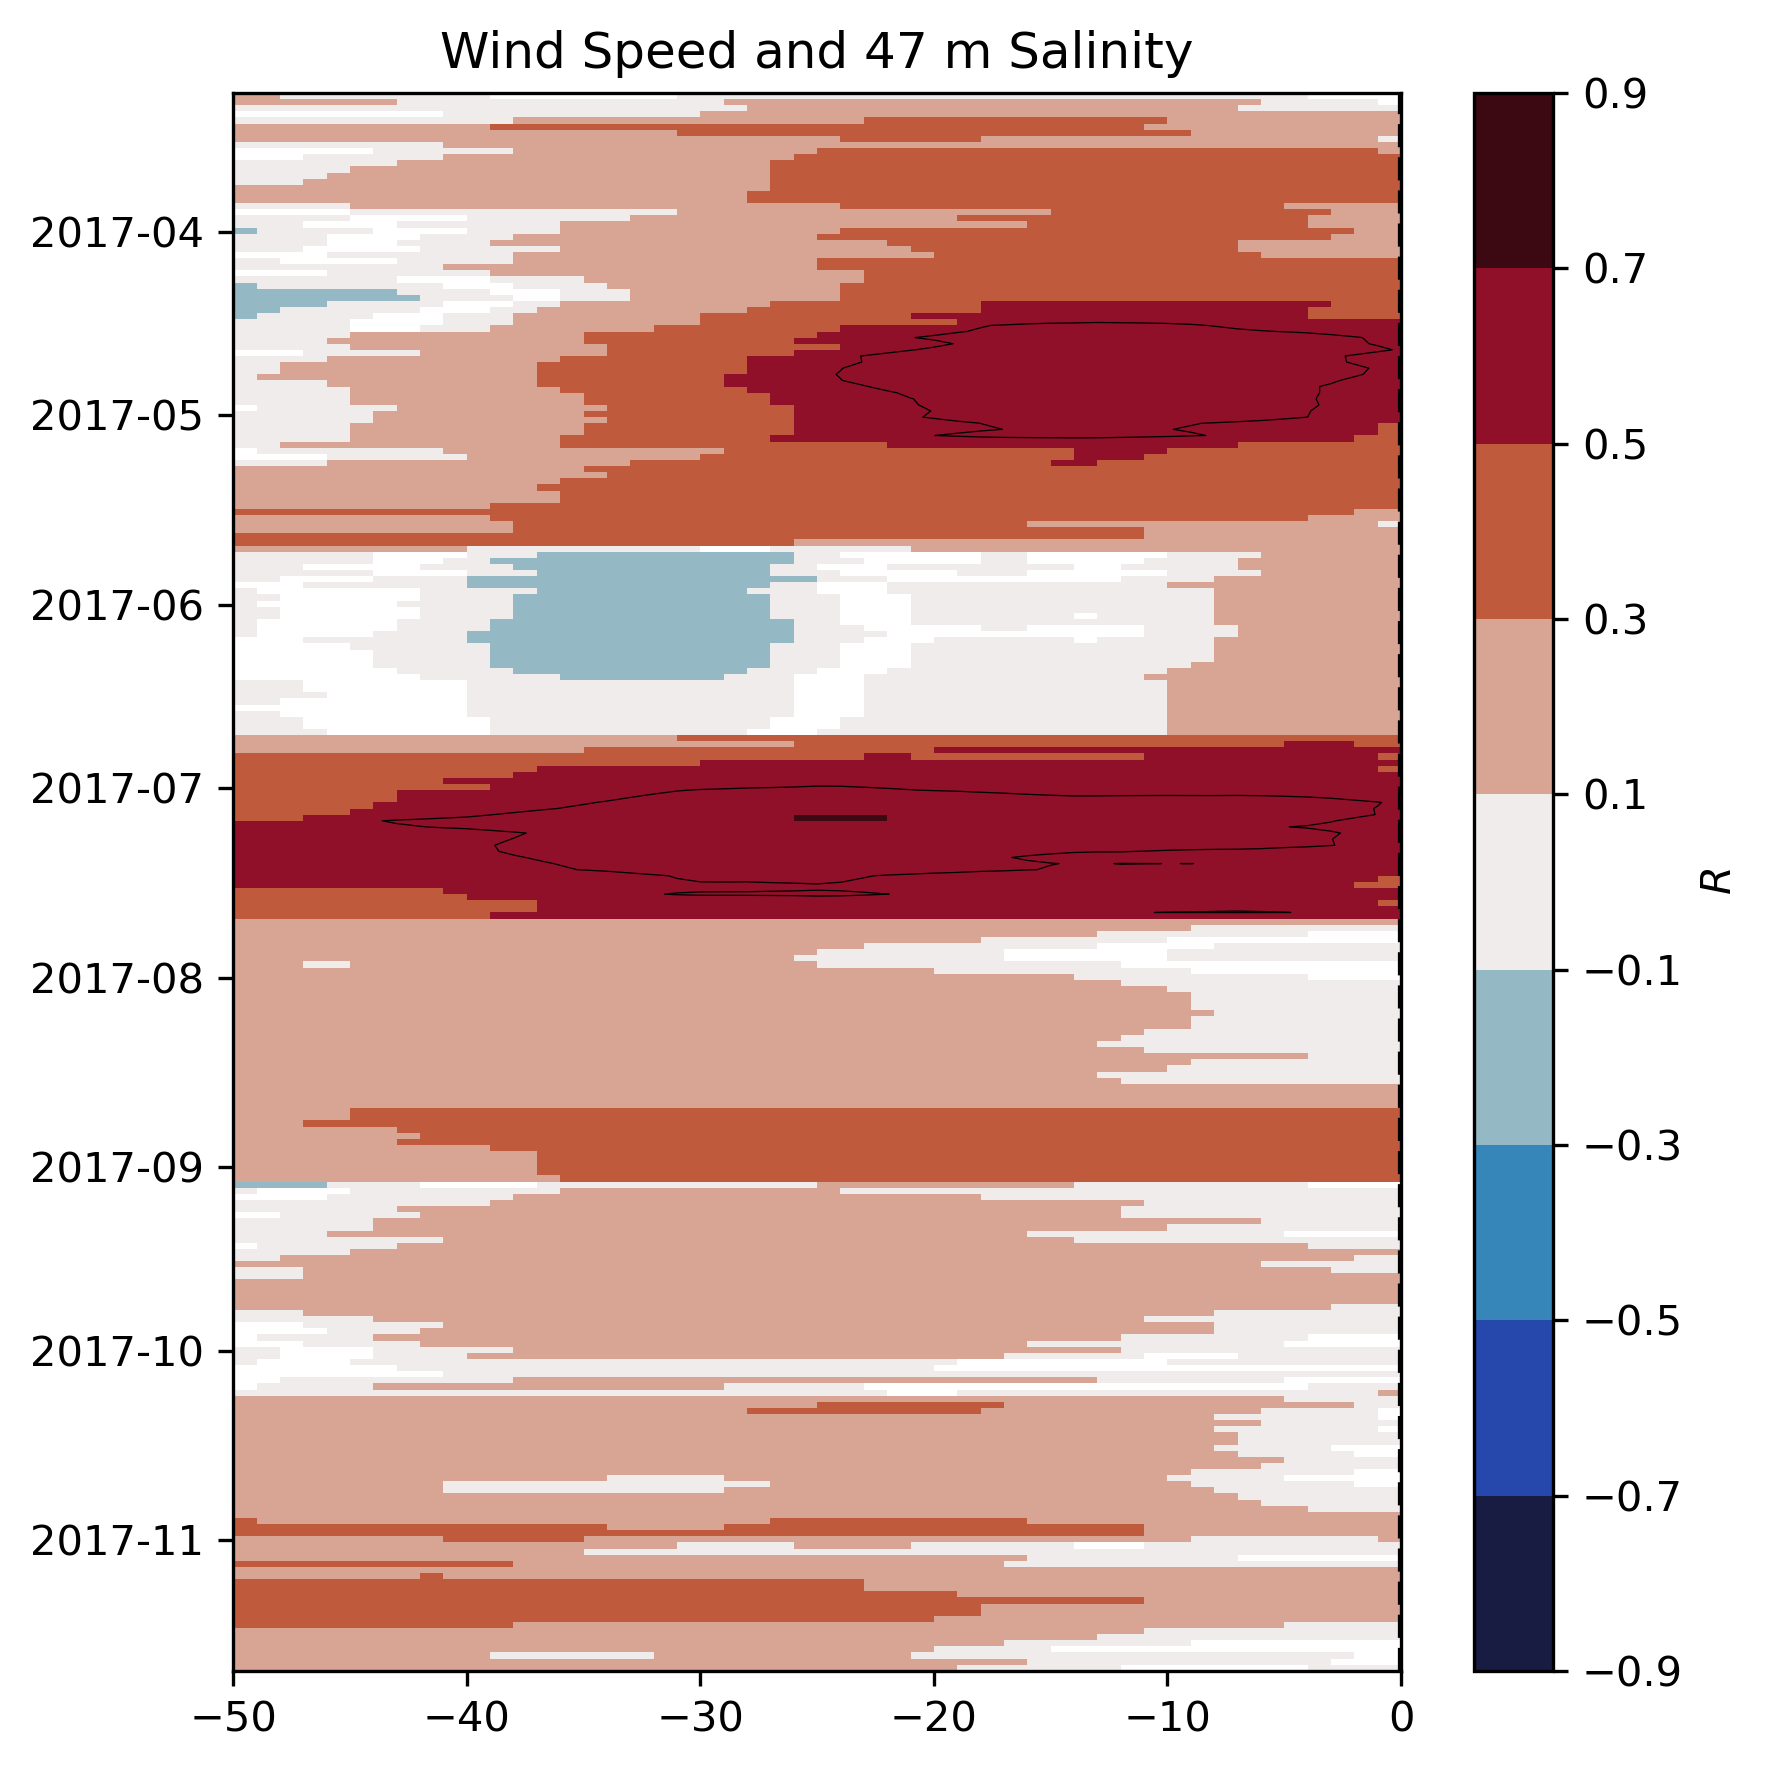

In [105]:
Plot_Corr_Pval(corr,pval,title='Wind Speed and 47 m Salinity')
plt.xlim(-50,0)

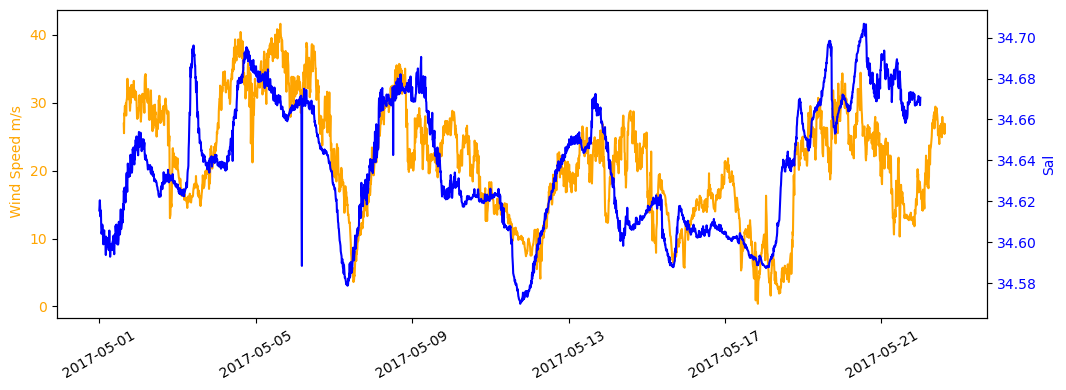

In [111]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(wspd.time.sel(time=slice('2017-05-01','2017-05-21')) + pd.Timedelta(15,'h'),wspd.sel(time=slice('2017-05-01','2017-05-21')),color='orange')
# ax1.plot(shear.time,shear.isel(distance=slice(0,5)).mean('distance').rolling(time=720,center=True).mean(),color='blue')
# ax1.plot(shear.time,shear.isel(distance=slice(5,11)).mean('distance').rolling(time=720,center=True).mean())
ax1.set_ylabel(r' Wind Speed m/s', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(sal.time.sel(time=slice('2017-05-01','2017-05-21')),sal.sel(time=slice('2017-05-01','2017-05-21')),color='blue')
ax2.set_ylabel('Sal',color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.tick_params(axis='x',labelsize=10,labelrotation=30)

(34.7, 34.85)

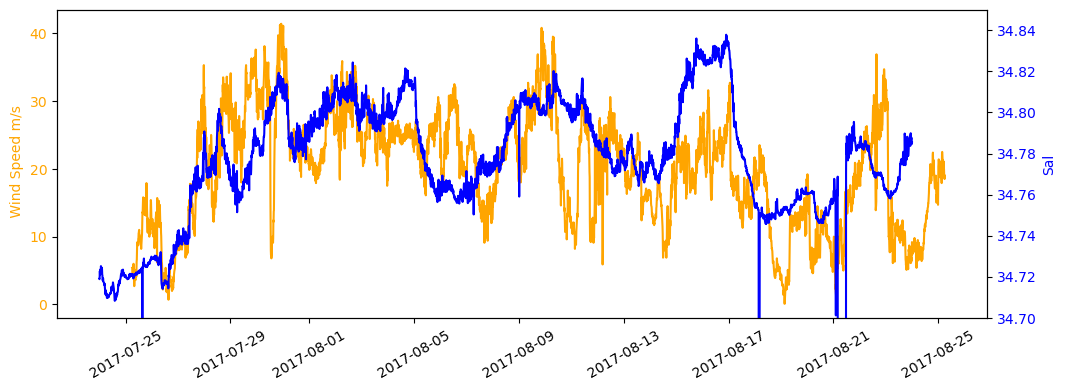

In [116]:
fig, ax1 = plt.subplots(figsize=(12,4))

ax1.plot(wspd.time.sel(time=slice('2017-07-24','2017-08-23')) + pd.Timedelta(30,'h'),wspd.sel(time=slice('2017-07-24','2017-08-23')),color='orange')
# ax1.plot(shear.time,shear.isel(distance=slice(0,5)).mean('distance').rolling(time=720,center=True).mean(),color='blue')
# ax1.plot(shear.time,shear.isel(distance=slice(5,11)).mean('distance').rolling(time=720,center=True).mean())
ax1.set_ylabel(r' Wind Speed m/s', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

ax2 = ax1.twinx()
ax2.plot(sal.time.sel(time=slice('2017-07-24','2017-08-23')),sal.sel(time=slice('2017-07-24','2017-08-23')),color='blue')
ax2.set_ylabel('Sal',color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax1.tick_params(axis='x',labelsize=10,labelrotation=30)
ax2.set_ylim(34.7,34.85)

The problem I was having with the sliding window function was due to dropping nans in the data arrays. I think this messed up the time axis. The better way to handle the nans is to linearly interpolate them so the time dimension does not get messed up and cause issues when slicing. 

### Other stuff 

In [65]:
# the above is a nice subset where we can clearly see that the 1100 m velocity lags the 1000 m velocity by about one day
# define this subset below to use for correlation testing example 
subset = vel.sel(time=slice('2018-04-13','2018-04-30'))

In [84]:
corr, pval = sliding_window_correlation(ds1=subset.isel(depth=1).speed,ds2=subset.isel(depth=0).speed,lag_hours=48,sliding_window=4)

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_48001/406004392.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm)


(-40.0, 40.0)

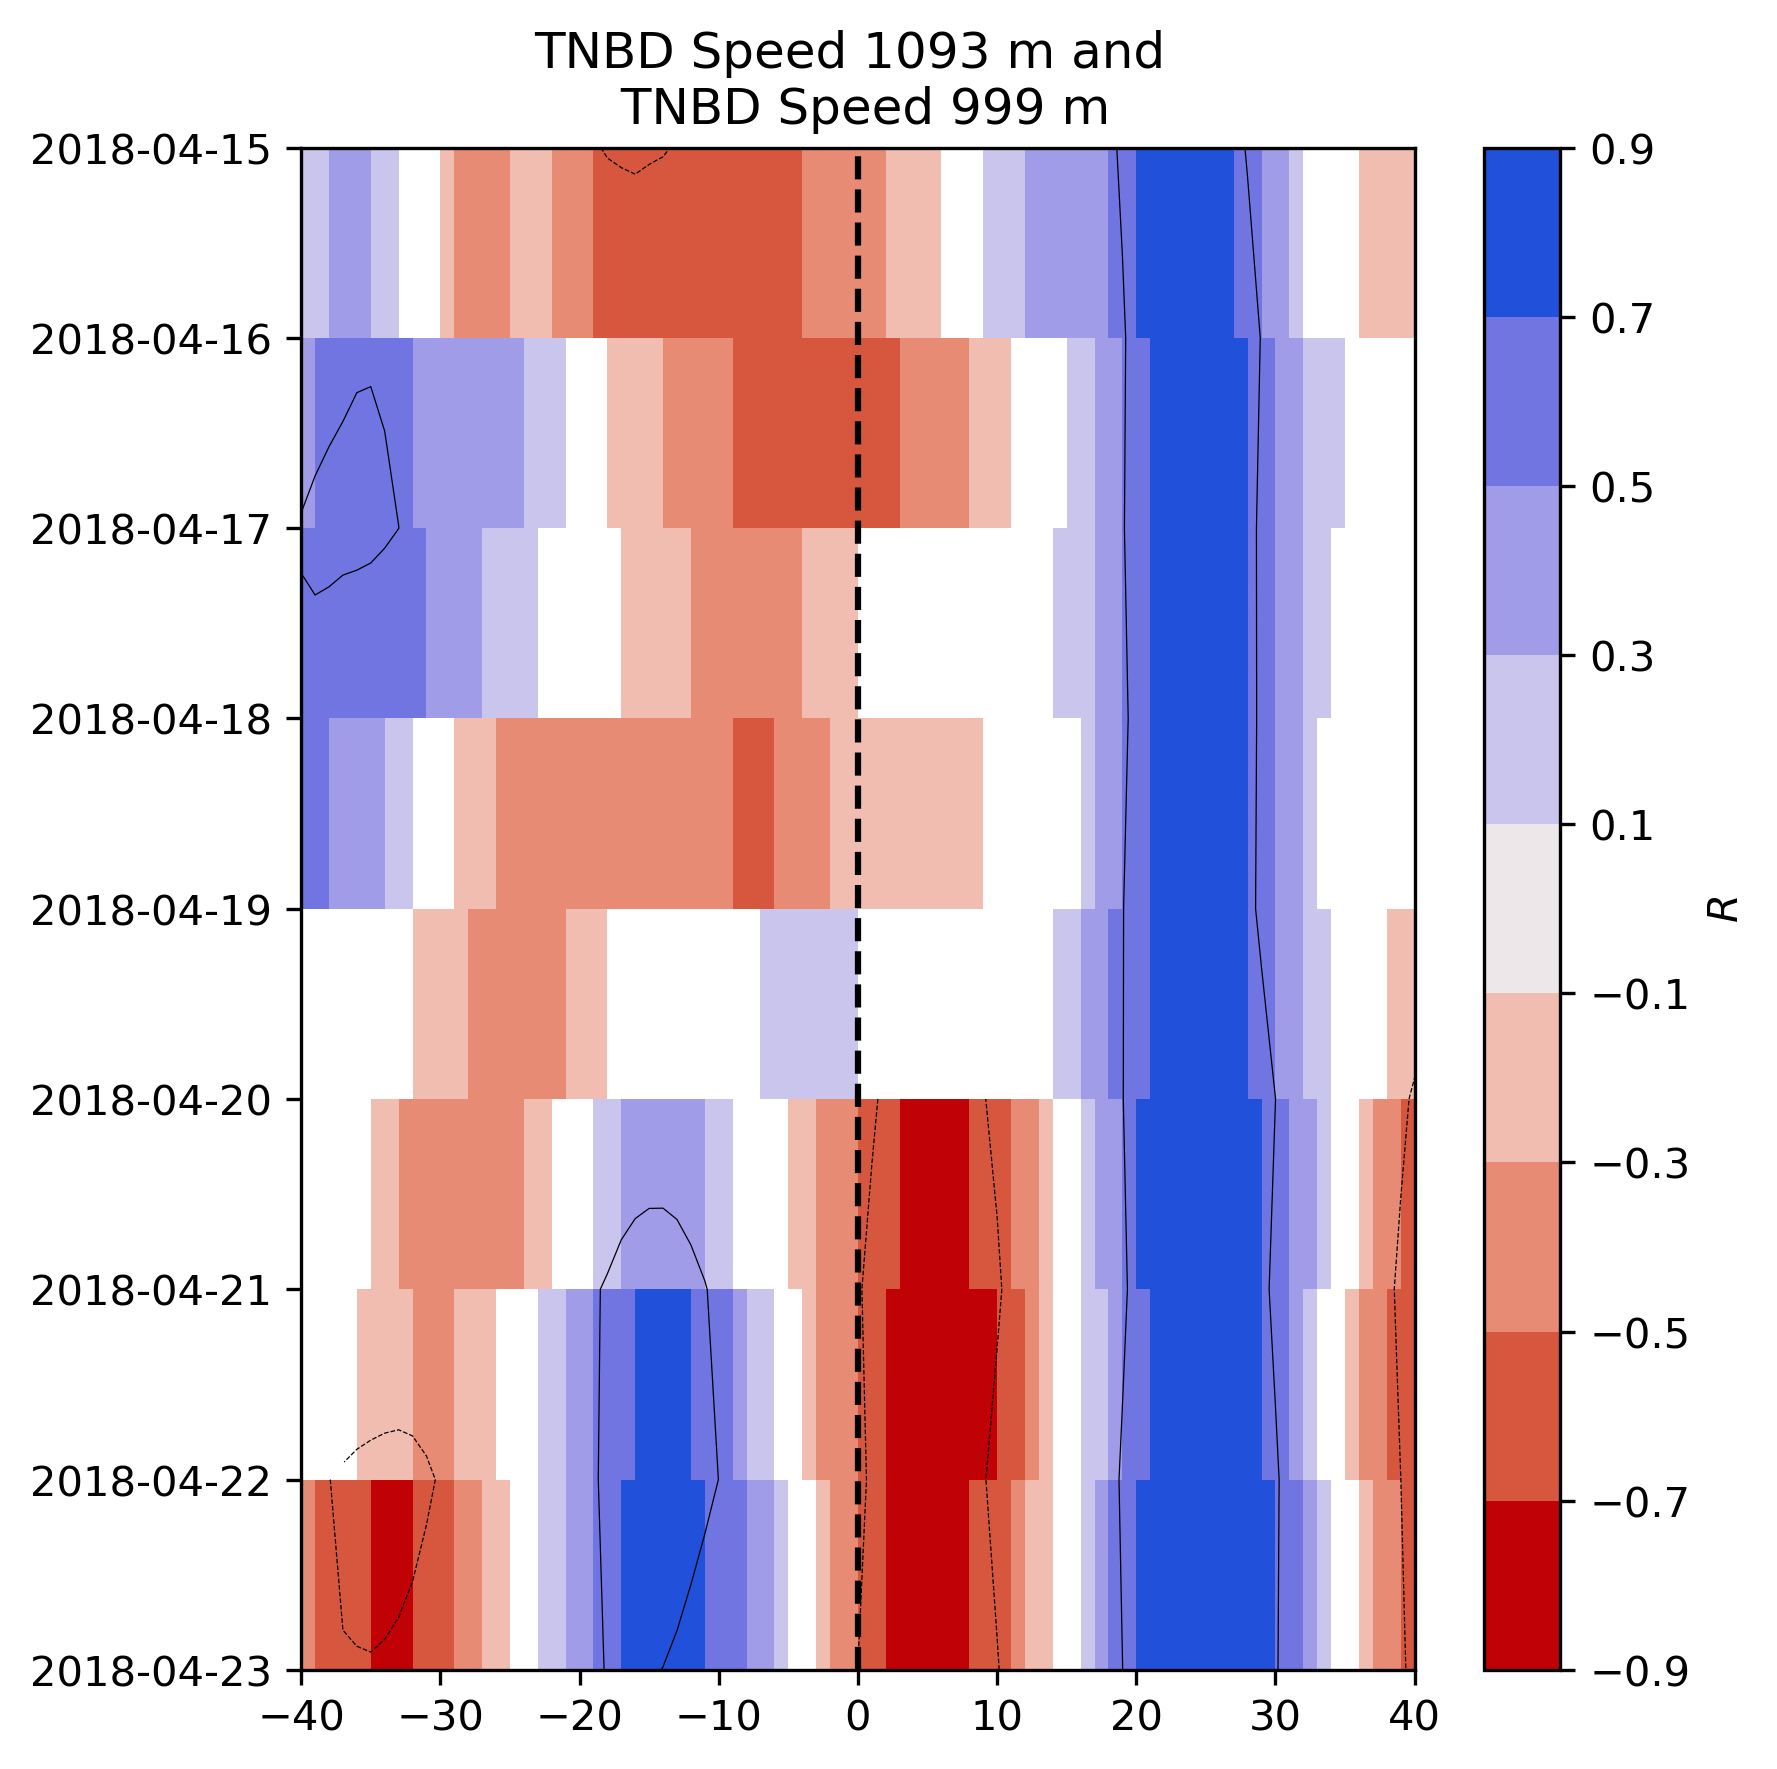

In [87]:
corr_significant = corr
corr_significant = corr_significant.where(pval < 0.05)
fig=plt.figure(figsize=(6,6),dpi=300) 

cmap = cc.cm.CET_D1_r#CET_D1A #matplotlib.cm.Spectral_r
bounds = np.arange(-0.9,1,.2)
norm =  matplotlib.colors.BoundaryNorm(bounds, cmap.N)


plt.pcolormesh(corr_significant.lag_hours,corr_significant.days,corr_significant,cmap = cmap, norm=norm)

plt.gca().invert_yaxis()
cbar = plt.colorbar()
cbar.set_label('$R$')


plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [0.6,1], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)
plt.contour(corr_significant.lag_hours,corr_significant.days,corr_significant, colors = 'k', levels = [-1,-0.6], linewidths = 0.3)#cmap=colorcet.cm.coolwarm)

# plt.xlim(-100,100)
plt.axvline(x=0,color='k',linestyle='dashed')

plt.title('TNBD Speed 1093 m and \n TNBD Speed 999 m')
plt.tight_layout()
plt.xlim(-40,40)

In [89]:
np.correlate(vel.isel(depth=0).speed,vel.isel(depth=1).speed)

array([80.917118])

In [92]:
# 1. Calculate cross-correlation using scipy.signal.correlate
# 'full' mode returns the convolution at each point of overlap
from scipy import correlate 
correlation_output = correlate(subset.isel(depth=0).speed - np.mean(subset.isel(depth=0).speed), subset.isel(depth=1).speed - np.mean(subset.isel(depth=1).speed), mode='full')

# 2. Determine the lags corresponding to the correlation output
# The lags range from -(len(series2)-1) to (len(series1)-1)
lags = np.arange(-(len(subset.isel(depth=0).speed) - 1), len(subset.isel(depth=1).speed))

# 3. Find the lag with the maximum absolute correlation
max_corr_index = np.argmax(np.abs(correlation_output))
optimal_lag = lags[max_corr_index]
max_correlation_value = correlation_output[max_corr_index]

/var/folders/yh/gzfzh54j7n572slt5126rl3m0000gn/T/ipykernel_48001/3638032335.py:4: DeprecationWarning: scipy.correlate is deprecated and will be removed in SciPy 2.0.0, use numpy.correlate instead
  correlation_output = correlate(subset.isel(depth=0).speed - np.mean(subset.isel(depth=0).speed), subset.isel(depth=1).speed - np.mean(subset.isel(depth=1).speed), mode='full')


In [93]:
optimal_lag

-48